In [7]:
import numpy as np

import os
import inspect
import sys
import pandas as pd
import charts
import time
import math
import datetime

from opengrid.library import houseprint
from scipy.spatial import distance
from scipy.signal import butter, lfilter, freqz

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

Server running in the folder /usr/local/opengrid/notebooks/Analysis/Thesis_Max&Jean/Block_detection at 127.0.0.1:51656


In [8]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
34 Sites created
34 Devices created
97 sensors created
Houseprint parsing complete


In [9]:
device = hp.find_device('FL03001441')
device.get_sensors()

[
     Fluksosensor
     Key: 81fb589c911e808daa96a2064bebed41
     Type: electricity
     , 
     Fluksosensor
     Key: 212ce724e124fbde0fb649396375d099
     Type: gas
     , 
     Fluksosensor
     Key: c57f45b21e2ec21ab427f172478e1ca4
     Type: water
     , 
     Fluksosensor
     Key: 156e0abc64b00c5e98dbd3c17883b5f6
     Type: electricity
     , 
     Fluksosensor
     Key: e5306ee3a4235498592fc89ee0ede353
     Type: electricity
     ]

In [5]:
print pd.__version__

0.19.2


In [6]:
#Get Gas data
head = pd.Timestamp('20151110')
tail = pd.Timestamp('20151118')
electr = hp.find_sensor('212ce724e124fbde0fb649396375d099')
df_el = electr.get_data(head,tail,diff=True,resample='min',  unit='kW')
df_el_dropna = df_el.dropna()
df_el = pd.DataFrame(df_el)

Using tmpo database from /data/.tmpo/tmpo.sqlite3


/usr/local/opengrid/opengrid/library/houseprint/sensor.py:280: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  newindex = data.resample(rule).index


In [7]:
if df_el.size <= 0:
    print "Dataframe is empty"
    
charts.plot(df_el.rolling(window=6,center=False).median(), show="inline", stock=True)

In [8]:
blocks.iloc[54]

NameError: name 'blocks' is not defined

In [9]:
charts.plot(df_el.ix[blocks.iloc[53]['start']:blocks.iloc[53]['stop']],show="inline", stock=True)

NameError: name 'blocks' is not defined

In [1655]:
def euclideanDistance(s1,s2):
    #Verwacht een numpy array
    dist = np.linalg.norm(s1-s2)
    return dist

In [10]:
def znormalization(ts):
    """
    ts - each column of ts is a time series (np.ndarray)
    """
    mus = ts.mean(axis = 0)
    stds = ts.std(axis = 0)
    return (ts - mus) / stds

In [11]:
def paa_transform(ts, n_pieces):
    """
    ts: the columns of which are time series represented by e.g. np.array
    n_pieces: M equally sized piecies into which the original ts is splitted
    """
    splitted = np.array_split(ts, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [12]:
def sax_transform(ts, n_pieces, alphabet):
    """
    ts: columns of which are time serieses represented by np.array
    n_pieces: number of segments in paa transformation
    alphabet: the letters to be translated to, e.g. "abcd", "ab"
    return np.array of ts's sax transformation
    Steps:
    1. znormalize
    2. ppa
    3. find norm distribution breakpoints by scipy.stats
    4. convert ppa transformation into strings
    """
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    return np.apply_along_axis(translate, 0, paa_ts)

In [13]:
def makeArray(array1):
    arrayValues=[]    
    for i in range(0, array1.size-1):
        if(i<array1.size):
             arrayValues.append(ord(array1.iloc[i])-97)
    df=pd.DataFrame(arrayValues)
    return df

In [14]:
def create_graph_from(df):
    list_with_graphs=[]
    list_with_graphs=pd.DataFrame(list_with_graphs)
    for i in range (0, df.index.size):
        list_with_graphs=list_with_graphs.append(df_el.ix[pd.Timestamp(df['start'][i]):pd.Timestamp(df['stop'][i])])
    return charts.plot(list_with_graphs, stock=True, show='inline')

In [15]:
def manhattanDistance2(s1,s2):
    dist = distance.cityblock(s1,s2)
    return dist

In [16]:
def check_max_consumption(start, stop, parent, threshold=4.0):
    head = pd.Timestamp(start)
    tail = pd.Timestamp(stop)
    temp = parent.ix[head:tail]
    
    if float(temp.values.max() - temp.values.min()) < threshold:
        return False
    else:
        return True

In [17]:
def check_duplicate(blocks, start, stop):
    
    #blocks.reset_index(drop=True, inplace=True)
    start = pd.Timestamp(start)
    stop = pd.Timestamp(stop)
    
    
    for i in range(blocks.index.size):
        check_start = pd.Timestamp(blocks['start'].iloc[i])
        check_stop = pd.Timestamp(blocks['stop'].iloc[i])
    
        if start == check_start or stop == check_stop or (start > check_start and stop < check_stop):
            if (stop - start)/(check_stop - check_start) > 0.75:
                return False, blocks
            
        if start < check_start and stop > check_stop:
            if (check_stop - check_start)/(stop - start) > 0.75:
                blocks = blocks.drop(blocks.index[i])
                
            
    return True, blocks

In [18]:
def find_blocks(df_parent, row_parent, blocks, df_original, first_time = True):
    min_lvl = 0
    start = False
    
    block_start = 0
    block_end = 0
    index_low = -1
    
    nr_of_blocks_start = blocks.size
    
    nested = row_parent
    
    if first_time:
        start = True
        min_lvl = df_parent['repeatedValues'].min()
        
    #append last value again
    post_index = df_parent.index[-1] + pd.Timedelta(minutes=1)

    temp = pd.DataFrame(data=[df_parent.iloc[-1]], index=[post_index], columns=['repeatedValues'])
    df_parent = df_parent.append(temp)

    df_parent.sort_index(inplace=True)

    for i in range(1, df_parent.size - 1):
        if start == False and df_parent['repeatedValues'].iloc[i - 1] - df_parent['repeatedValues'].iloc[i] == 0:
            min_lvl = df_parent['repeatedValues'].iloc[i]
            start = True
        
        if start == True and df_parent['repeatedValues'].iloc[i] > min_lvl and df_parent['repeatedValues'].iloc[i - 1] == min_lvl:
            block_start = df_parent.index[i - 1]
            
        if start == True and block_start != 0 and df_parent['repeatedValues'].iloc[i] <= min_lvl:
            block_end = df_parent.index[i]
            
            #Match if the length is more than 10% less than the parent
            temp = pd.DataFrame(data=[[str(block_start), str(block_end), nested]], columns=['start', 'stop', 'nested_in'])
            
            if float(df_parent.index.size - df_parent.ix[block_start : block_end].index.size) / float(df_parent.index.size) > 0.10:
                # check if block is longer than 15 min
                if(block_end - block_start > pd.Timedelta(minutes=15)):
                    # check max consumption is greater than threshold
                    if check_max_consumption(start=block_start, stop=block_end, parent=df_rm):
                        # Check for duplicates
                        check, blocks = check_duplicate(blocks, block_start, block_end)
                        if check:
                            #print [block_start, block_end]
                            blocks = blocks.append(temp, ignore_index=True)
            
            df_parent2 = df_original.ix[block_start : block_end]
            row_parent = blocks.index.size - 1
            blocks = find_blocks(df_parent2, row_parent, blocks, df_original, False)
            blocks =  blocks.drop_duplicates(subset=['start', 'stop'], keep= 'first')
            block_start = 0
            block_end = 0
            
        if start == True and block_start == 0 and df_parent['repeatedValues'].iloc[i] < min_lvl:
            #Lvl dropped below min value so the min value was not assigned properly
            # Store the timestamp where the value is the lowest for the first time.
            if index_low == -1:
                index_low = i
                
            if df_parent['repeatedValues'].iloc[index_low] > df_parent['repeatedValues'].iloc[i]:
                index_low = i
            
            if df_parent['repeatedValues'].iloc[i+1] > df_parent['repeatedValues'].iloc[i]:
                
                #Match if the length is more than 10% less than the parent
                temp = pd.DataFrame(data=[[str(df_parent.index[0]), str(df_parent.index[index_low]), nested]], columns=['start', 'stop', 'nested_in'])
            
                if float(df_parent.index.size - df_parent.ix[df_parent.index[0] : df_parent.index[index_low]].index.size) / float(df_parent.index.size) > 0.10:
                    # check if block is longer than 10 min
                    if(df_parent.index[index_low]-df_parent.index[0] > pd.Timedelta(minutes=15)):
                        # check max consumption is greater than threshold
                        if check_max_consumption(start=df_parent.index[0], stop=df_parent.index[index_low], parent=df_rm):
                            # check for duplicates
                            check, blocks = check_duplicate(blocks, df_parent.index[0], df_parent.index[index_low])
                            if check:
                                blocks = blocks.append(temp, ignore_index=True)
                
                min_lvl = df_parent['repeatedValues'].iloc[index_low]
                
    #blocks.reset_index(drop=True, inplace=True)
    return blocks

In [19]:
class MyValidationError(Exception):
    pass

In [20]:
def sax_rm_shortage(dataframe):
    
    if dataframe.size <= 0:
        raise MyValidationError("Dataframe must have a size bigger than 0")
    
        return None, None
    
    #Take the rolling mean to filter out peaks
    df_rm = dataframe.rolling(window=6,center=False).median()
    df_rm.index = df_rm.index - pd.Timedelta(minutes=3)
    df_rm = df_rm.dropna()
    
    #saxtransform
    saxTransmation = sax_transform(df_rm, df_rm.size/3, "abcdefghijklmnop")
    
    #Revert the letters to numbers
    letters=pd.DataFrame(saxTransmation)
    letters.columns=['col1']
    lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

    repeatedValues=np.repeat(lettersToNumSax.as_matrix(),3) #expects an array
    #make sure the dataframes are of the same length to join the data and the index
    shortage = df_rm.size - repeatedValues.size
    if shortage > 0:
        repeatedValues = np.append(repeatedValues, [repeatedValues[-1]]*shortage)

    elif shortage < 0:
        repeatedValues = repeatedValues[0:repeatedValues.size + shortage]
    
    shortage = df_rm.size - repeatedValues.size
    
    df_repeatedValues = pd.DataFrame(index=df_rm.index, data= repeatedValues, columns=['repeatedValues'])
    return df_repeatedValues, df_rm
    

In [21]:
def blockdetection(df_repeatedValues, df_rm):
#pre- and append a zero to make sure the sample starts and ends with the same value
    for i in range(0, 2):
        pre_index = df_repeatedValues.index[0] - pd.Timedelta(minutes=1)
        post_index = df_repeatedValues.index[-1] + pd.Timedelta(minutes=1)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[pre_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[post_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        df_repeatedValues.sort_index(inplace=True)
    
    #Do the actual searching
    blocks = pd.DataFrame(columns=['start', 'stop', 'nested_in'])
    blocks = find_blocks(df_repeatedValues, -1, blocks, df_repeatedValues)
    
    #plot the dataframe with all the blocks
    fig, ax = plt.subplots()
    #ax.plot(df_repeatedValues.index, df_repeatedValues, color='grey')
    ax.plot(df_rm.index, df_rm, color='grey')

    colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


    for i in range(0, blocks.index.size):
        #ax.axvspan(blocks['start'].iloc[i], blocks['stop'].iloc[i], alpha=0.1, color=colors[3])
        ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i])), str(pd.Timestamp(blocks['stop'].iloc[i]) + pd.Timedelta(minutes=2)), alpha=0.1, color=colors[3])
        #ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i])), str(pd.Timestamp(blocks['stop'].iloc[i])), alpha=0.1, color=colors[3])


    plt.show()
    
    #return the rolling mean equivalent and the blocks dataframe
    return df_rm, blocks

In [1670]:
 def looping_through_list(df_with_values, array_to_compare):
    start=time.time()
    result_list=[]
    for i in range(0, df_with_values.index.size - array_to_compare.index.size+1):
        frame = df_with_values[i:i+array_to_compare.index.size]
        manhattan_distance = manhattanDistance2(frame, array_to_compare)
        
        start_ts = frame.index[0]
        stop_ts = frame.index[-1]
        if (i==0) or (manhattan_distance != result_list[len(result_list)-1][0]):
            result_list.append([manhattan_distance, start_ts, stop_ts]) 
#     print time.time() - start
    return result_list

In [1626]:
def local_minima(score_list):
    local_minima_scores = [row[0] for row in score_list]
    arr_n = np.asarray(local_minima_scores)
    df = pd.DataFrame(score_list, columns=["score","start","stop"])
    tr_f = np.r_[True, arr_n[1:] < arr_n[:-1]] & np.r_[arr_n[:-1] < arr_n[1:], True]
    tr_f_list = tr_f.tolist()
    df_local_minima = df.loc[tr_f_list]
    return df_local_minima

In [1627]:
    #POSSIBILITY
#     ts=(list_view[0][2]-list_view[0][1])/10
#     threshold_value=(ts / np.timedelta64(1, 'm')).astype(int)
#     threshold_value

In [1628]:
def ts_correction(local_minima_sc):
    result_list_n=[]
    max_value = 0
    for i in range(0, local_minima_sc.index.size):
        current_row = local_minima_sc.iloc[i]
        if(i==0):
            result_list_n.append(current_row)
        else:
            previous_row  = result_list_n[len(result_list_n)-1]
            if(current_row['start'] >= previous_row['start']) and (current_row['start'] <= previous_row['stop']):
                #Inside
                if(current_row[0] <= previous_row[0]):
                    ind,d = find_score(result_list_n, previous_row[0])
                    result_list_n[ind] = current_row
            #Outside       
            else:
                result_list_n.append(current_row)
    return result_list_n

In [1629]:
def find_score(data, score):
    for ind, d in enumerate(data):
        if score == d['score']:
            return ind, d
    return None, None

In [21]:
def calculate_threshold_value(df_result, nr_of_best_values, factor):
    list_of_best_values=[]
    i = 0
    df.sort_values("score")
    for i in range(0, nr_of_best_values):
        list_of_best_values.append(df_result.iloc[i])
    list_of_best_values=pd.DataFrame(list_of_best_values)
    mean=list_of_best_values.mean()
    threshold=mean*factor
    return df_result.loc[df_result['score']<=threshold[0]]

In [32]:
def calculate_threshold_value(df_result, nr_of_best_values, factor):
    df_result.sort_values("score")
    threshold = df_result[0:nr_of_best_values].mean() * factor
    return df_result.loc[df_result['score']<=threshold[0]]

In [18]:
df=[1,2,3,4,5,6,7,8,7,5,7,8,9,6,8,2,5,23,684,5,32,165,432,1651,651,651,32,1651,51,231,0,320,21,20,2]
df=pd.DataFrame(df)
df.columns=["score"]

In [33]:
calculate_threshold_value(df, 5, 1.5)

score
0       1
1       2
2       3
3       4
15      2
30      0
34      2

In [22]:
calculate_threshold_value(df, 5, 1.5)

score
0       1
1       2
2       3
3       4
15      2
30      0
34      2

In [ ]:
 for i in range(0, nr_of_best_values):
        list_of_best_values.append(df_result.iloc[i])

In [1631]:
def find_big_blocks(list_of_blocks):
    list_blocks=[]
    for i in range(0, list_of_blocks.index.size):
        if(blocks['nested_in'][i] == -1.0):
            list_blocks.append(list_of_blocks.iloc[i])
    list_blocks=pd.DataFrame(list_blocks)
    list_blocks.reset_index(drop=True, inplace=True)
    return list_blocks

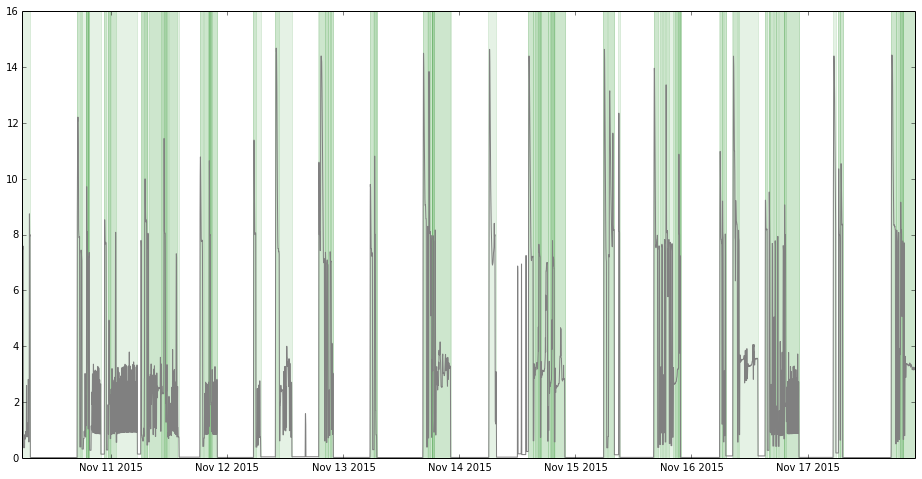

In [1632]:
try:
    frame, df_rm=sax_rm_shortage(df_el)
    originalrm, blocks = blockdetection(frame, df_rm)
    
except MyValidationError as exception:
    # handle exception here and get error message
    print exception

<h4> Indexing dataframe </h4>

<h3> Testing new algorithm </h3>

In [33]:
# l1= [1,2,3,4,5,6,7,8,9]
# l2= [1,3,2,4,5,6,7,8,9]

In [1610]:
 def looping_through_list(df_with_values, array_to_compare):
    start=time.time()
    result_list=[]
#     print "lol1"
    for i in range(0, len(df_with_values[0]) - len(array_to_compare)+1):
#         print "lol3"
        frame = [df_with_values[0][i:i+len(array_to_compare)],df_with_values[1][i:i+len(array_to_compare)]]
#         manhattan_distance = manhattanDistance2(frame, array_to_compare)
        sm=difflib.SequenceMatcher(None,frame[1],array_to_compare)
        ratio = sm.ratio()
        start_ts = frame[0][1]
        stop_ts = frame[0][-1]
#         print "lol2"
        if (i==0) or (ratio != result_list[len(result_list)-1][0]):
#             print "lol"
            result_list.append([ratio, start_ts, stop_ts]) 
#     print time.time() - start
    return result_list

In [1624]:
df_rm

212ce724e124fbde0fb649396375d099
2015-11-10 05:43:00+00:00                          8.143493
2015-11-10 05:44:00+00:00                          8.097384
2015-11-10 05:45:00+00:00                          8.097384
2015-11-10 05:46:00+00:00                          7.661337
2015-11-10 05:47:00+00:00                          7.473214
2015-11-10 05:48:00+00:00                          7.473214
2015-11-10 05:49:00+00:00                          7.473214
2015-11-10 05:50:00+00:00                          7.500000
2015-11-10 05:51:00+00:00                          7.500000
2015-11-10 05:52:00+00:00                          7.527058
2015-11-10 05:53:00+00:00                          7.584239
2015-11-10 05:54:00+00:00                          7.584239
2015-11-10 05:55:00+00:00                          7.584239
2015-11-10 05:56:00+00:00                          4.580138
2015-11-10 05:57:00+00:00                          0.984166
2015-11-10 05:58:00+00:00                          0.362173
2015-11-10 05:59:00+00:00                          0.362173
2015-11-10 06:00:00+00:00                          0.362173
2015-11-10 06:01:00+00:00                          0.362173
2015-11-10 06:02:00+00:00                          0.362173
2015-11-10 06:03:00+00:00                          0.362173
2015-11-10 06:04:00+00:00                          0.362173
2015-11-10 06:05:00+00:00                          0.362173
2015-11-10 06:06:00+00:00                          0.362173
2015-11-10 06:07:00+00:00                          0.362173
2015-11-10 06:08:00+00:00                          0.362173
2015-11-10 06:09:00+00:00                          0.362173
2015-11-10 06:10:00+00:00                          0.362173
2015-11-10 06:11:00+00:00                          0.362173
2015-11-10 06:12:00+00:00                          0.672092
...                                                     ...
2015-11-17 21:39:00+00:00                          3.197321
2015-11-17 21:40:00+00:00                          3.226022
2015-11-17 21:41:00+00:00                          3.235590
2015-11-17 21:42:00+00:00                          3.235590
2015-11-17 21:43:00+00:00                          3.235590
2015-11-17 21:44:00+00:00                          3.206888
2015-11-17 21:45:00+00:00                          3.180484
2015-11-17 21:46:00+00:00                          3.166511
2015-11-17 21:47:00+00:00                          3.166511
2015-11-17 21:48:00+00:00                          3.151259
2015-11-17 21:49:00+00:00                          3.146612
2015-11-17 21:50:00+00:00                          3.146612
2015-11-17 21:51:00+00:00                          3.181444
2015-11-17 21:52:00+00:00                          3.224513
2015-11-17 21:53:00+00:00                          3.224513
2015-11-17 21:54:00+00:00                          3.238992
2015-11-17 21:55:00+00:00                          3.243243
2015-11-17 21:56:00+00:00                          3.243243
2015-11-17 21:57:00+00:00                          3.250369
2015-11-17 21:58:00+00:00                          3.243243
2015-11-17 21:59:00+00:00                          3.243243
2015-11-17 22:00:00+00:00                          3.214542
2015-11-17 22:01:00+00:00                          3.171528
2015-11-17 22:02:00+00:00                          3.157555
2015-11-17 22:03:00+00:00                          3.157555
2015-11-17 22:04:00+00:00                          3.157555
2015-11-17 22:05:00+00:00                          3.167676
2015-11-17 22:06:00+00:00                          3.181649
2015-11-17 22:07:00+00:00                          3.197456
2015-11-17 22:08:00+00:00                          3.211678

[11066 rows x 1 columns]

In [1613]:
test_list = looping_through_list(df_rm_list, looping)

TypeError: object of type 'float' has no len()

In [36]:
# len(df_rm_list)

In [37]:
# df_rm_list = [df_rm.index.tolist(), df_rm[df_rm.columns[0]].values.tolist()]

In [38]:
# frame= [df_rm_list[0][0:5], df_rm_list[1][0:5]]

In [39]:
# frame[1]

In [718]:
looping_list=looping.values.tolist()
df_rm_list = df_rm.values.tolist()

In [1597]:
looping_list = looping['212ce724e124fbde0fb649396375d099'].values.tolist()

In [1598]:
df_rm_list=df_rm['212ce724e124fbde0fb649396375d099'].values.tolist()

In [1601]:
df_rm_list[1]

8.097383720931248

In [1602]:
sm=difflib.SequenceMatcher(None,looping_list,df_rm_list)
sm.ratio()

0.05210350290441824

In [1603]:
ma_df_rm = df_rm.as_matrix()

In [1604]:
df_rm.columns[0]

'212ce724e124fbde0fb649396375d099'

In [1605]:
looping = df_rm.ix[blocks.iloc[1]['start']:blocks.iloc[1]['stop']]

In [1607]:
import difflib

In [1609]:
ts1=pd.Timestamp('2015-11-10 12:25:00+0000')
ts2=pd.Timestamp('2015-11-10 17:19:00+0000')

ts=df_rm.ix[ts1:ts2]
sm=difflib.SequenceMatcher(None,looping_list,df_rm_list)
sm.ratio()

0.05210350290441824

<h2> Creating types </h2>

In [1650]:
blocks['Type']=1
k=0
for i in range(0, blocks.index.size):
    if(blocks['nested_in'][i]==-1.0):
        j = 0
        blocks['Type'][i] = blocks.index[i]
        k=i
    else:
#         print blocks.index[k],"",j
        blocks['Type'][i] = blocks.index[k],".. ",j
        j=j+1

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
# def looping_through_list_original(df_list_blocks):
#     start_time = time.time()
#     time_now = time.time()
#     #Create list of costs
#     cost_list = []
#     #Crating variable 'j'. This will make sure we don't check the same frames twice.
#     j=1
#     #Other variable
#     k=0
#     #new frame to store duration and lengths of said dataframes
#     length_vs_duration=[]
#     for i in range(0, df_list_blocks.index.size):
#         start = df_list_blocks.iloc[i][0]
#         stop = df_list_blocks.iloc[i][1]
#         #This will create a dataframe with all the values between the start and stop timestamp.
#         #This is used for comparing these values using a similarity algorithm with the others
# #         if(k == 1):
# #             print min(result)[0], "score for length: ", df_original.index.size
# #             length_vs_duration.extend([min(result)[0], df_original.index.size])
# #             time_now = time.time()
#         df_original = df_el.ix[pd.Timestamp(start):pd.Timestamp(stop)]
#         #Type of the block
#         type_original = df_list_blocks.iloc[i][3]
#         #Original or nested in
#         original_or_nested = df_list_blocks.iloc[i][2]
#         #get the big blocks
#         df_list_big_blocks = find_big_blocks(df_list_blocks)
#         nr_loops=0
#         print type_original
#         if(k==1) and (original_or_nested == -1.0):
#             j=j+1
#         for i in range(j, df_list_big_blocks.index.size):
#             df_new = df_el.ix[pd.Timestamp(df_list_big_blocks.iloc[i][0]):pd.Timestamp(df_list_big_blocks.iloc[i][1])]
#             if(df_new.index.size >= df_original.index.size) and not(df_new.equals(df_original)) :
#                 nr_loops=nr_loops+1
# #                 print "looping: ", nr_loops
#                 result = looping_through_list(df_new, df_original)
#                 if(min(result)[0] not in [row[0][0] for row in cost_list]):
#                     cost_list.append((min(result), ('Original: Type', type_original, 'against type', df_list_big_blocks.iloc[i][3]), df_original.index.size))
#             elif(df_new.index.size < df_original.index.size):
#                 nr_loops=nr_loops+1                
# #                 print "looping: ", nr_loops
#                 result = looping_through_list(df_original, df_new)
#                 if(min(result)[0] not in [row[0][0] for row in cost_list]):
#                     cost_list.append((min(result), ('Substitute: Type', df_list_big_blocks.iloc[i][3], 'against original type', type_original), df_new.index.size))
#             k=1
#     print  "Time to complete: ", time.time() - start_time
#     return cost_list, length_vs_duration

In [1666]:
def looping_through_list_original(df_list_blocks, df_el):
    start_time = time.time()
    time_now = time.time()
    #Create list of costs
    cost_list = []
    #Crating variable 'j'. This will make sure we don't check the same frames twice.
    j=1
    #Other variable
    k=0
    #new frame to store duration and lengths of said dataframes
    smaller = True
    length_vs_duration=[]
    for i in range(0, df_list_blocks.index.size):
        start = df_list_blocks.iloc[i][0]
        stop = df_list_blocks.iloc[i][1]
        df_original = df_el.ix[pd.Timestamp(start):pd.Timestamp(stop)]
        #Type of the block
        type_original = df_list_blocks.iloc[i][3]
        #Original or nested in
        original_or_nested = df_list_blocks.iloc[i][2]
        #get the big blocks
        df_list_big_blocks = find_big_blocks(df_list_blocks)
        nr_loops=0
        print type_original
        if(k==1) and (original_or_nested == -1.0):
            j=j+1
        for i in range(j, df_list_big_blocks.index.size):
            df_new = df_el.ix[pd.Timestamp(df_list_big_blocks.iloc[i][0]):pd.Timestamp(df_list_big_blocks.iloc[i][1])]
            
            if(df_new.index.size >= df_original.index.size) and not(df_new.equals(df_original)):
                smaller = True
                nr_loops=nr_loops+1
                result = looping_through_list(df_new, df_original)
            elif(df_new.index.size < df_original.index.size):
                smaller = False
                nr_loops=nr_loops+1
                result = looping_through_list(df_original, df_new)
            local_minima_scores = local_minima(result)
            df_ts_corr = pd.DataFrame(ts_correction(local_minima_scores))
            
            if(df_ts_corr.index.size >= 10):
#                 print "enough values"
                save_values = []
                ts_corr_sorted = df_ts_corr.sort_values("score")
                df_best_v = calculate_threshold_value(pd.DataFrame(ts_corr_sorted),10,1.5)
                for k in range(0, df_best_v.index.size):
                    if(smaller):
                        cost_list.append(([df_best_v.iloc[k][0], df_best_v.iloc[k][1], df_best_v.iloc[k][2]], ('Original: Type', type_original, 'against type', df_list_big_blocks.iloc[i][3]), df_original.index.size))
                    else:
                        cost_list.append(([df_best_v.iloc[k][0], df_best_v.iloc[k][1], df_best_v.iloc[k][2]], ('Substitute: Type', df_list_big_blocks.iloc[i][3], 'against original type', type_original), df_new.index.size))
#                 values_to_save = save_values
#                 cost_list.append(values_to_save)
            else:
#                 print "not enough values in ts_corr"
                values_to_save = min(result)   
                if(smaller):
                    cost_list.append((values_to_save, ('Original: Type', type_original, 'against type', df_list_big_blocks.iloc[i][3]), df_original.index.size))
                else:
                    cost_list.append((values_to_save, ('Substitute: Type', df_list_big_blocks.iloc[i][3], 'against original type', type_original), df_new.index.size))
            k=1
    print  "Time to complete: ", time.time() - start_time
    return cost_list, length_vs_duration

In [2]:
cost_list

NameError: name 'cost_list' is not defined

In [1644]:
def create_dataframe(list_view):
    df_list_view=[]
    df_list_view=pd.DataFrame(df_list_view)

    df_substitutes=[]
    df_substitutes=pd.DataFrame(df_substitutes)
    for i in range(0, len(list_view[0])):      
            df_list_view = df_list_view.append(pd.DataFrame([[list_view[0][i][0][0],list_view[0][i][0][1],list_view[0][i][0][2], list_view[0][i][1][1],list_view[0][i][1][3], list_view[0][i][2]]], columns=['Manhattan', 'start', 'stop', 'original', 'against', 'length'], index=[i]))
    return df_list_view

In [1645]:
def calculating_median(df):
    median_list = []
    median_1 = df.loc[(df['length'] >= 10) & (df['length'] <=20)]['Manhattan'].median()    
    median_2 = df.loc[(df['length'] >= 20)& (df['length'] <= 30)]['Manhattan'].median()    
    median_3 = df.loc[(df['length'] >= 30) & (df['length'] <=50)]['Manhattan'].median()    
    median_4 = df.loc[(df['length'] >= 50) & (df['length'] <=70)]['Manhattan'].median()    
    median_5 = df.loc[(df['length'] >= 70) & (df['length'] <=100)]['Manhattan'].median()    
    median_6 = df.loc[(df['length'] >= 100) & (df['length'] <=150)]['Manhattan'].median()    
    median_7 = df.loc[(df['length'] >= 150) & (df['length'] <=200)]['Manhattan'].median()    
    median_8 = df.loc[(df['length'] >= 200) & (df['length'] <=300)]['Manhattan'].median()    
    median_9 = df.loc[(df['length'] >= 300)]['Manhattan'].median()
    median_list.extend([median_1, median_2, median_3, median_4,median_5,median_6,median_7,median_8,median_9])
    index = ['10-20', '20-30', '30-50', '50-70', '70-100', '100-150', '150-200', '200-300', '>300']
    median_df = pd.DataFrame({'median_manhattan':median_list}, index=index)
    return median_df

In [1646]:
def calculate_ratio(df):
    df.reset_index(drop=True, inplace=True)
    df['ratio']=1.0
    result=df.ix[:,'length']/df.ix[:,'Manhattan']
    df['ratio'] = result
    return df

In [1647]:
def remove_bad_matches(df):
    calculate_ratio(df)
    median_df = calculating_median(df)
    df_ratio_length = []
    df_ratio_length = pd.DataFrame(df_ratio_length)
    for i in range(0, median_df.index.size):    
        if(median_df.index[i][2]== "-") and (median_df.index[i][0] != ">"):
            start = median_df.index[i][0:2]
            stop = median_df.index[i][3:6]
        elif(median_df.index[i][2] != "-") and (median_df.index[i][0] != ">"):
            start = median_df.index[i][0:3]
            stop = median_df.index[i][4:7]
        elif(median_df.index[i][0] == ">"):
            start = median_df.index[i][1:4]
            stop = start*6
        df_length = df.loc[(df['length'] >int(start)) & (df['length'] <=int(stop))]   
        median = df_length['Manhattan'].median()
        df_ratio_length = df_ratio_length.append(df_length.loc[df_length['Manhattan'] >= median*1]) 
    df_ratio_length = (df_ratio_length.loc[df_ratio_length['ratio']<0.5])
    df_list_v_drop = df.drop(df_ratio_length.index)
    return df_list_v_drop
    

In [1648]:
def remove_long_machines(df, length):
    df_too_long = df.loc[df['length']>length]
    df_list_v_drop = df.drop(df_too_long.index)
    return df_list_v_drop

<h3> Creating dataframe </h3>

In [ ]:
df_list_view_18_df_rm = create_dataframe(list_view_18_df_rm)

<h3> removing bad matches </h3>

In [1641]:
df_rm

212ce724e124fbde0fb649396375d099
2015-11-10 05:43:00+00:00                          8.143493
2015-11-10 05:44:00+00:00                          8.097384
2015-11-10 05:45:00+00:00                          8.097384
2015-11-10 05:46:00+00:00                          7.661337
2015-11-10 05:47:00+00:00                          7.473214
2015-11-10 05:48:00+00:00                          7.473214
2015-11-10 05:49:00+00:00                          7.473214
2015-11-10 05:50:00+00:00                          7.500000
2015-11-10 05:51:00+00:00                          7.500000
2015-11-10 05:52:00+00:00                          7.527058
2015-11-10 05:53:00+00:00                          7.584239
2015-11-10 05:54:00+00:00                          7.584239
2015-11-10 05:55:00+00:00                          7.584239
2015-11-10 05:56:00+00:00                          4.580138
2015-11-10 05:57:00+00:00                          0.984166
2015-11-10 05:58:00+00:00                          0.362173
2015-11-10 05:59:00+00:00                          0.362173
2015-11-10 06:00:00+00:00                          0.362173
2015-11-10 06:01:00+00:00                          0.362173
2015-11-10 06:02:00+00:00                          0.362173
2015-11-10 06:03:00+00:00                          0.362173
2015-11-10 06:04:00+00:00                          0.362173
2015-11-10 06:05:00+00:00                          0.362173
2015-11-10 06:06:00+00:00                          0.362173
2015-11-10 06:07:00+00:00                          0.362173
2015-11-10 06:08:00+00:00                          0.362173
2015-11-10 06:09:00+00:00                          0.362173
2015-11-10 06:10:00+00:00                          0.362173
2015-11-10 06:11:00+00:00                          0.362173
2015-11-10 06:12:00+00:00                          0.672092
...                                                     ...
2015-11-17 21:39:00+00:00                          3.197321
2015-11-17 21:40:00+00:00                          3.226022
2015-11-17 21:41:00+00:00                          3.235590
2015-11-17 21:42:00+00:00                          3.235590
2015-11-17 21:43:00+00:00                          3.235590
2015-11-17 21:44:00+00:00                          3.206888
2015-11-17 21:45:00+00:00                          3.180484
2015-11-17 21:46:00+00:00                          3.166511
2015-11-17 21:47:00+00:00                          3.166511
2015-11-17 21:48:00+00:00                          3.151259
2015-11-17 21:49:00+00:00                          3.146612
2015-11-17 21:50:00+00:00                          3.146612
2015-11-17 21:51:00+00:00                          3.181444
2015-11-17 21:52:00+00:00                          3.224513
2015-11-17 21:53:00+00:00                          3.224513
2015-11-17 21:54:00+00:00                          3.238992
2015-11-17 21:55:00+00:00                          3.243243
2015-11-17 21:56:00+00:00                          3.243243
2015-11-17 21:57:00+00:00                          3.250369
2015-11-17 21:58:00+00:00                          3.243243
2015-11-17 21:59:00+00:00                          3.243243
2015-11-17 22:00:00+00:00                          3.214542
2015-11-17 22:01:00+00:00                          3.171528
2015-11-17 22:02:00+00:00                          3.157555
2015-11-17 22:03:00+00:00                          3.157555
2015-11-17 22:04:00+00:00                          3.157555
2015-11-17 22:05:00+00:00                          3.167676
2015-11-17 22:06:00+00:00                          3.181649
2015-11-17 22:07:00+00:00                          3.197456
2015-11-17 22:08:00+00:00                          3.211678

[11066 rows x 1 columns]

In [1671]:
#Looping through blocks
list_view_18_df_rm_n = looping_through_list_original(blocks, df_rm)

0
1
(1, '.. ', 0)
(1, '.. ', 1)
(1, '.. ', 2)
(1, '.. ', 3)
(1, '.. ', 4)
(1, '.. ', 5)
8
(8, '.. ', 0)
(8, '.. ', 1)
(8, '.. ', 2)
(8, '.. ', 3)
13
(13, '.. ', 0)
(13, '.. ', 1)
(13, '.. ', 2)
(13, '.. ', 3)
(13, '.. ', 4)
(13, '.. ', 5)
(13, '.. ', 6)
21
(21, '.. ', 0)
(21, '.. ', 1)
(21, '.. ', 2)
(21, '.. ', 3)
(21, '.. ', 4)
27
(27, '.. ', 0)
29
(29, '.. ', 0)
31
(31, '.. ', 0)
(31, '.. ', 1)
(31, '.. ', 2)
(31, '.. ', 3)
(31, '.. ', 4)
37
(37, '.. ', 0)
(37, '.. ', 1)
(37, '.. ', 2)
41
(41, '.. ', 0)
(41, '.. ', 1)
(41, '.. ', 2)
(41, '.. ', 3)
(41, '.. ', 4)
(41, '.. ', 5)
48
49
(49, '.. ', 0)
(49, '.. ', 1)
(49, '.. ', 2)
(49, '.. ', 3)
(49, '.. ', 4)
(49, '.. ', 5)
(49, '.. ', 6)
(49, '.. ', 7)
(49, '.. ', 8)
59
(59, '.. ', 0)
(59, '.. ', 1)
62
63
(63, '.. ', 0)
(63, '.. ', 1)
(63, '.. ', 2)
(63, '.. ', 3)
(63, '.. ', 4)
(63, '.. ', 5)
(63, '.. ', 6)
71
(71, '.. ', 0)
(71, '.. ', 1)
(71, '.. ', 2)
75
(75, '.. ', 0)
(75, '.. ', 1)
78
(78, '.. ', 0)
(78, '.. ', 1)
(78, '.. ', 2)

In [1672]:
#Creating panda dataframe
df_list_view_18_df_rm_n = create_dataframe(list_view_18_df_rm_n)

In [1673]:
df_list_view_18_df_rm_n

Manhattan                     start                      stop  \
0     139.086185 2015-11-10 19:21:00+00:00 2015-11-10 21:00:00+00:00   
1     132.205434 2015-11-10 22:50:00+00:00 2015-11-11 00:29:00+00:00   
2     154.772481 2015-11-11 11:09:00+00:00 2015-11-11 12:48:00+00:00   
3     118.800650 2015-11-11 18:45:00+00:00 2015-11-11 20:24:00+00:00   
4     289.364361 2015-11-10 05:43:00+00:00 2015-11-10 07:14:00+00:00   
5     158.652140 2015-11-12 10:36:00+00:00 2015-11-12 12:15:00+00:00   
6     213.549541 2015-11-12 19:56:00+00:00 2015-11-12 21:35:00+00:00   
7     334.334313 2015-11-10 05:43:00+00:00 2015-11-10 07:08:00+00:00   
8     199.107708 2015-11-13 18:32:00+00:00 2015-11-13 20:11:00+00:00   
9     681.342139 2015-11-10 05:43:00+00:00 2015-11-10 07:20:00+00:00   
10    171.694734 2015-11-14 19:25:00+00:00 2015-11-14 21:04:00+00:00   
11    434.315933 2015-11-15 06:13:00+00:00 2015-11-15 07:52:00+00:00   
12     22.440639 2015-11-10 07:06:00+00:00 2015-11-10 07:22:00+00:00   
13    191.341892 2015-11-15 19:55:00+00:00 2015-11-15 21:34:00+00:00   
14    339.419079 2015-11-10 05:58:00+00:00 2015-11-10 07:17:00+00:00   
15    248.525700 2015-11-16 09:38:00+00:00 2015-11-16 11:17:00+00:00   
16    154.983075 2015-11-16 19:14:00+00:00 2015-11-16 20:53:00+00:00   
17    260.622717 2015-11-10 06:45:00+00:00 2015-11-10 07:22:00+00:00   
18    239.234995 2015-11-10 06:26:00+00:00 2015-11-10 07:21:00+00:00   
19    229.675214 2015-11-17 19:29:00+00:00 2015-11-17 21:08:00+00:00   
20    517.623614 2015-11-10 22:36:00+00:00 2015-11-11 03:31:00+00:00   
21    608.183698 2015-11-11 06:51:00+00:00 2015-11-11 11:46:00+00:00   
22    328.478399 2015-11-10 17:00:00+00:00 2015-11-10 20:37:00+00:00   
23    155.773974 2015-11-10 17:03:00+00:00 2015-11-10 18:34:00+00:00   
24    561.468782 2015-11-10 18:27:00+00:00 2015-11-10 21:55:00+00:00   
25    700.217666 2015-11-10 18:31:00+00:00 2015-11-10 21:35:00+00:00   
26    229.865414 2015-11-10 17:00:00+00:00 2015-11-10 18:25:00+00:00   
27    735.448795 2015-11-13 16:33:00+00:00 2015-11-13 21:28:00+00:00   
28    362.305001 2015-11-10 17:00:00+00:00 2015-11-10 18:37:00+00:00   
29    685.477063 2015-11-14 14:14:00+00:00 2015-11-14 19:09:00+00:00   
...          ...                       ...                       ...   
1809   10.534621 2015-11-17 18:18:00+00:00 2015-11-17 18:34:00+00:00   
1810   31.382614 2015-11-17 18:39:00+00:00 2015-11-17 18:55:00+00:00   
1811   32.682164 2015-11-17 19:08:00+00:00 2015-11-17 19:24:00+00:00   
1812   33.580170 2015-11-17 19:27:00+00:00 2015-11-17 19:43:00+00:00   
1813   35.605984 2015-11-17 19:47:00+00:00 2015-11-17 20:03:00+00:00   
1814   43.845665 2015-11-17 17:54:00+00:00 2015-11-17 18:10:00+00:00   
1815   66.919232 2015-11-17 20:16:00+00:00 2015-11-17 20:32:00+00:00   
1816   67.827189 2015-11-17 20:59:00+00:00 2015-11-17 21:15:00+00:00   
1817   68.277298 2015-11-17 21:17:00+00:00 2015-11-17 21:33:00+00:00   
1818   68.609915 2015-11-17 21:47:00+00:00 2015-11-17 22:03:00+00:00   
1819  176.505130 2015-11-17 05:12:00+00:00 2015-11-17 05:37:00+00:00   
1820   75.894617 2015-11-17 06:32:00+00:00 2015-11-17 06:57:00+00:00   
1821   44.837579 2015-11-17 18:56:00+00:00 2015-11-17 19:21:00+00:00   
1822  172.074047 2015-11-17 05:12:00+00:00 2015-11-17 05:34:00+00:00   
1823   75.024496 2015-11-17 06:35:00+00:00 2015-11-17 06:57:00+00:00   
1824   26.835826 2015-11-17 18:32:00+00:00 2015-11-17 18:54:00+00:00   
1825  278.006767 2015-11-16 18:27:00+00:00 2015-11-16 19:04:00+00:00   
1826  248.326321 2015-11-16 18:09:00+00:00 2015-11-16 19:04:00+00:00   
1827  115.925286 2015-11-17 20:00:00+00:00 2015-11-17 21:01:00+00:00   
1828  243.082517 2015-11-16 19:09:00+00:00 2015-11-16 19:46:00+00:00   
1829  217.721525 2015-11-16 19:09:00+00:00 2015-11-16 20:04:00+00:00   
1830  354.852139 2015-11-17 19:07:00+00:00 2015-11-17 22:08:00+00:00   
1831  124.244617 2015-11-17 05:13:00+00:00 2015-11-17 05:35:00+00:00   
1832   27.517094 2015-11-17 06:19:00+00:00 2015

In [1663]:
df_list_view_18_df_rm_n

Manhattan                     start                      stop  \
0     25.071071 2015-11-10 19:22:00+00:00 2015-11-10 21:01:00+00:00   
1     23.864830 2015-11-10 22:50:00+00:00 2015-11-11 00:29:00+00:00   
2     24.579563 2015-11-11 11:05:00+00:00 2015-11-11 12:44:00+00:00   
3     23.443960 2015-11-11 18:46:00+00:00 2015-11-11 20:25:00+00:00   
4     42.119029 2015-11-10 05:43:00+00:00 2015-11-10 07:14:00+00:00   
5     23.548722 2015-11-12 10:36:00+00:00 2015-11-12 12:15:00+00:00   
6     32.334903 2015-11-12 19:55:00+00:00 2015-11-12 21:34:00+00:00   
7     46.856256 2015-11-10 05:43:00+00:00 2015-11-10 07:08:00+00:00   
8     26.582720 2015-11-13 18:32:00+00:00 2015-11-13 20:11:00+00:00   
9     74.306032 2015-11-10 05:43:00+00:00 2015-11-10 07:20:00+00:00   
10    20.953842 2015-11-14 19:25:00+00:00 2015-11-14 21:04:00+00:00   
11    59.406594 2015-11-15 06:12:00+00:00 2015-11-15 07:51:00+00:00   
12     7.822170 2015-11-10 07:06:00+00:00 2015-11-10 07:22:00+00:00   
13    23.453694 2015-11-15 19:56:00+00:00 2015-11-15 21:35:00+00:00   
14    48.596327 2015-11-10 05:43:00+00:00 2015-11-10 07:02:00+00:00   
15    28.263100 2015-11-16 09:39:00+00:00 2015-11-16 11:18:00+00:00   
16    24.492199 2015-11-16 19:14:00+00:00 2015-11-16 20:53:00+00:00   
17    53.189501 2015-11-10 06:45:00+00:00 2015-11-10 07:22:00+00:00   
18    42.064139 2015-11-10 06:27:00+00:00 2015-11-10 07:22:00+00:00   
19    29.933841 2015-11-17 19:29:00+00:00 2015-11-17 21:08:00+00:00   
20    47.471309 2015-11-10 22:36:00+00:00 2015-11-11 03:31:00+00:00   
21    50.925502 2015-11-11 06:52:00+00:00 2015-11-11 11:47:00+00:00   
22    35.768769 2015-11-10 17:00:00+00:00 2015-11-10 20:37:00+00:00   
23    26.444941 2015-11-10 17:02:00+00:00 2015-11-10 18:33:00+00:00   
24    50.400818 2015-11-10 17:00:00+00:00 2015-11-10 20:28:00+00:00   
25    66.613517 2015-11-10 18:31:00+00:00 2015-11-10 21:35:00+00:00   
26    35.597723 2015-11-10 17:00:00+00:00 2015-11-10 18:25:00+00:00   
27    64.441888 2015-11-13 16:32:00+00:00 2015-11-13 21:27:00+00:00   
28    46.496591 2015-11-10 17:00:00+00:00 2015-11-10 18:37:00+00:00   
29    51.551351 2015-11-14 14:14:00+00:00 2015-11-14 19:09:00+00:00   
...         ...                       ...                       ...   
1813   3.108846 2015-11-17 18:18:00+00:00 2015-11-17 18:34:00+00:00   
1814  10.249213 2015-11-17 19:27:00+00:00 2015-11-17 19:43:00+00:00   
1815  10.710860 2015-11-17 18:40:00+00:00 2015-11-17 18:56:00+00:00   
1816  11.395760 2015-11-17 19:08:00+00:00 2015-11-17 19:24:00+00:00   
1817  11.489461 2015-11-17 19:47:00+00:00 2015-11-17 20:03:00+00:00   
1818  16.095694 2015-11-17 17:55:00+00:00 2015-11-17 18:11:00+00:00   
1819  17.833200 2015-11-17 20:16:00+00:00 2015-11-17 20:32:00+00:00   
1820  17.933307 2015-11-17 20:59:00+00:00 2015-11-17 21:15:00+00:00   
1821  18.099772 2015-11-17 21:17:00+00:00 2015-11-17 21:33:00+00:00   
1822  18.285753 2015-11-17 21:47:00+00:00 2015-11-17 22:03:00+00:00   
1823  41.699448 2015-11-17 05:12:00+00:00 2015-11-17 05:37:00+00:00   
1824  19.556337 2015-11-17 06:32:00+00:00 2015-11-17 06:57:00+00:00   
1825  11.002674 2015-11-17 18:55:00+00:00 2015-11-17 19:20:00+00:00   
1826  42.053581 2015-11-17 05:12:00+00:00 2015-11-17 05:34:00+00:00   
1827  21.358585 2015-11-17 06:37:00+00:00 2015-11-17 06:59:00+00:00   
1828   7.716604 2015-11-17 18:33:00+00:00 2015-11-17 18:55:00+00:00   
1829  54.189442 2015-11-16 18:27:00+00:00 2015-11-16 19:04:00+00:00   
1830  40.720424 2015-11-16 18:09:00+00:00 2015-11-16 19:04:00+00:00   
1831  17.874331 2015-11-17 20:02:00+00:00 2015-11-17 21:03:00+00:00   
1832  45.130374 2015-11-16 19:09:00+00:00 2015-11-16 19:46:00+00:00   
1833  37.879205 2015-11-16 19:09:00+00:00 2015-11-16 20:04:00+00:00   
1834  34.966943 2015-11-17 19:07:00+00:00 2015-11-17 22:08:00+00:00   
1835  31.936764 2015-11-17 05:13:00+00:00 2015-11-17 05:35:00+00:00   
1836   9.737779 2015-11-17 06:19:00+00:00 2015-11-17 06:41:00+00:00   
1837   9.289764 2015-11-17 19:

In [1659]:
df_list_view_18_df_rm_n

Manhattan                     start                      stop  \
0     25.071071 2015-11-10 19:22:00+00:00 2015-11-10 21:01:00+00:00   
1     23.864830 2015-11-10 22:50:00+00:00 2015-11-11 00:29:00+00:00   
2     24.579563 2015-11-11 11:05:00+00:00 2015-11-11 12:44:00+00:00   
3     23.443960 2015-11-11 18:46:00+00:00 2015-11-11 20:25:00+00:00   
4     42.119029 2015-11-10 05:43:00+00:00 2015-11-10 07:14:00+00:00   
5     23.548722 2015-11-12 10:36:00+00:00 2015-11-12 12:15:00+00:00   
6     32.334903 2015-11-12 19:55:00+00:00 2015-11-12 21:34:00+00:00   
7     46.856256 2015-11-10 05:43:00+00:00 2015-11-10 07:08:00+00:00   
8     26.582720 2015-11-13 18:32:00+00:00 2015-11-13 20:11:00+00:00   
9     74.306032 2015-11-10 05:43:00+00:00 2015-11-10 07:20:00+00:00   
10    20.953842 2015-11-14 19:25:00+00:00 2015-11-14 21:04:00+00:00   
11    59.406594 2015-11-15 06:12:00+00:00 2015-11-15 07:51:00+00:00   
12     7.822170 2015-11-10 07:06:00+00:00 2015-11-10 07:22:00+00:00   
13    23.453694 2015-11-15 19:56:00+00:00 2015-11-15 21:35:00+00:00   
14    48.596327 2015-11-10 05:43:00+00:00 2015-11-10 07:02:00+00:00   
15    28.263100 2015-11-16 09:39:00+00:00 2015-11-16 11:18:00+00:00   
16    24.492199 2015-11-16 19:14:00+00:00 2015-11-16 20:53:00+00:00   
17    53.189501 2015-11-10 06:45:00+00:00 2015-11-10 07:22:00+00:00   
18    42.064139 2015-11-10 06:27:00+00:00 2015-11-10 07:22:00+00:00   
19    29.933841 2015-11-17 19:29:00+00:00 2015-11-17 21:08:00+00:00   
20    47.471309 2015-11-10 22:36:00+00:00 2015-11-11 03:31:00+00:00   
21    50.925502 2015-11-11 06:52:00+00:00 2015-11-11 11:47:00+00:00   
22    35.768769 2015-11-10 17:00:00+00:00 2015-11-10 20:37:00+00:00   
23    26.444941 2015-11-10 17:02:00+00:00 2015-11-10 18:33:00+00:00   
24    50.400818 2015-11-10 17:00:00+00:00 2015-11-10 20:28:00+00:00   
25    66.613517 2015-11-10 18:31:00+00:00 2015-11-10 21:35:00+00:00   
26    35.597723 2015-11-10 17:00:00+00:00 2015-11-10 18:25:00+00:00   
27    64.441888 2015-11-13 16:32:00+00:00 2015-11-13 21:27:00+00:00   
28    46.496591 2015-11-10 17:00:00+00:00 2015-11-10 18:37:00+00:00   
29    51.551351 2015-11-14 14:14:00+00:00 2015-11-14 19:09:00+00:00   
...         ...                       ...                       ...   
1350  51.296159 2015-11-16 15:57:00+00:00 2015-11-16 16:34:00+00:00   
1351  33.343085 2015-11-17 06:19:00+00:00 2015-11-17 07:08:00+00:00   
1352  18.726413 2015-11-17 19:46:00+00:00 2015-11-17 20:35:00+00:00   
1353  23.937215 2015-11-17 05:13:00+00:00 2015-11-17 05:29:00+00:00   
1354   9.485989 2015-11-17 06:19:00+00:00 2015-11-17 06:35:00+00:00   
1355   3.108846 2015-11-17 18:18:00+00:00 2015-11-17 18:34:00+00:00   
1356  10.249213 2015-11-17 19:27:00+00:00 2015-11-17 19:43:00+00:00   
1357  10.710860 2015-11-17 18:40:00+00:00 2015-11-17 18:56:00+00:00   
1358  11.395760 2015-11-17 19:08:00+00:00 2015-11-17 19:24:00+00:00   
1359  11.489461 2015-11-17 19:47:00+00:00 2015-11-17 20:03:00+00:00   
1360  41.699448 2015-11-17 05:12:00+00:00 2015-11-17 05:37:00+00:00   
1361  19.556337 2015-11-17 06:32:00+00:00 2015-11-17 06:57:00+00:00   
1362  11.002674 2015-11-17 18:55:00+00:00 2015-11-17 19:20:00+00:00   
1363  42.053581 2015-11-17 05:12:00+00:00 2015-11-17 05:34:00+00:00   
1364  21.358585 2015-11-17 06:37:00+00:00 2015-11-17 06:59:00+00:00   
1365   7.716604 2015-11-17 18:33:00+00:00 2015-11-17 18:55:00+00:00   
1366  54.189442 2015-11-16 18:27:00+00:00 2015-11-16 19:04:00+00:00   
1367  40.720424 2015-11-16 18:09:00+00:00 2015-11-16 19:04:00+00:00   
1368  17.874331 2015-11-17 20:02:00+00:00 2015-11-17 21:03:00+00:00   
1369  45.130374 2015-11-16 19:09:00+00:00 2015-11-16 19:46:00+00:00   
1370  37.879205 2015-11-16 19:09:00+00:00 2015-11-16 20:04:00+00:00   
1371  34.966943 2015-11-17 19:07:00+00:00 2015-11-17 22:08:00+00:00   
1372  31.936764 2015-11-17 05:13:00+00:00 2015-11-17 05:35:00+00:00   
1373   9.737779 2015-11-17 06:19:00+00:00 2015-11-17 06:41:00+00:00   
1374   9.289764 2015-11-17 19:

In [1654]:
df_list_view_18_df_rm_n

Manhattan                     start                      stop  \
0     139.086185 2015-11-10 19:21:00+00:00 2015-11-10 21:00:00+00:00   
1     132.205434 2015-11-10 22:50:00+00:00 2015-11-11 00:29:00+00:00   
2     154.772481 2015-11-11 11:09:00+00:00 2015-11-11 12:48:00+00:00   
3     118.800650 2015-11-11 18:45:00+00:00 2015-11-11 20:24:00+00:00   
4     289.364361 2015-11-10 05:43:00+00:00 2015-11-10 07:14:00+00:00   
5     158.652140 2015-11-12 10:36:00+00:00 2015-11-12 12:15:00+00:00   
6     213.549541 2015-11-12 19:56:00+00:00 2015-11-12 21:35:00+00:00   
7     334.334313 2015-11-10 05:43:00+00:00 2015-11-10 07:08:00+00:00   
8     199.107708 2015-11-13 18:32:00+00:00 2015-11-13 20:11:00+00:00   
9     681.342139 2015-11-10 05:43:00+00:00 2015-11-10 07:20:00+00:00   
10    171.694734 2015-11-14 19:25:00+00:00 2015-11-14 21:04:00+00:00   
11    434.315933 2015-11-15 06:13:00+00:00 2015-11-15 07:52:00+00:00   
12     22.440639 2015-11-10 07:06:00+00:00 2015-11-10 07:22:00+00:00   
13    191.341892 2015-11-15 19:55:00+00:00 2015-11-15 21:34:00+00:00   
14    339.419079 2015-11-10 05:58:00+00:00 2015-11-10 07:17:00+00:00   
15    248.525700 2015-11-16 09:38:00+00:00 2015-11-16 11:17:00+00:00   
16    154.983075 2015-11-16 19:14:00+00:00 2015-11-16 20:53:00+00:00   
17    260.622717 2015-11-10 06:45:00+00:00 2015-11-10 07:22:00+00:00   
18    239.234995 2015-11-10 06:26:00+00:00 2015-11-10 07:21:00+00:00   
19    229.675214 2015-11-17 19:29:00+00:00 2015-11-17 21:08:00+00:00   
20    517.623614 2015-11-10 22:36:00+00:00 2015-11-11 03:31:00+00:00   
21    608.183698 2015-11-11 06:51:00+00:00 2015-11-11 11:46:00+00:00   
22    328.478399 2015-11-10 17:00:00+00:00 2015-11-10 20:37:00+00:00   
23    155.773974 2015-11-10 17:03:00+00:00 2015-11-10 18:34:00+00:00   
24    561.468782 2015-11-10 18:27:00+00:00 2015-11-10 21:55:00+00:00   
25    700.217666 2015-11-10 18:31:00+00:00 2015-11-10 21:35:00+00:00   
26    229.865414 2015-11-10 17:00:00+00:00 2015-11-10 18:25:00+00:00   
27    735.448795 2015-11-13 16:33:00+00:00 2015-11-13 21:28:00+00:00   
28    362.305001 2015-11-10 17:00:00+00:00 2015-11-10 18:37:00+00:00   
29    685.477063 2015-11-14 14:14:00+00:00 2015-11-14 19:09:00+00:00   
...          ...                       ...                       ...   
1351  162.226357 2015-11-17 06:19:00+00:00 2015-11-17 07:08:00+00:00   
1352   94.997339 2015-11-17 18:18:00+00:00 2015-11-17 19:07:00+00:00   
1353   68.915384 2015-11-17 05:13:00+00:00 2015-11-17 05:29:00+00:00   
1354   22.513610 2015-11-17 06:19:00+00:00 2015-11-17 06:35:00+00:00   
1355   10.534621 2015-11-17 18:18:00+00:00 2015-11-17 18:34:00+00:00   
1356   31.382614 2015-11-17 18:39:00+00:00 2015-11-17 18:55:00+00:00   
1357   32.682164 2015-11-17 19:08:00+00:00 2015-11-17 19:24:00+00:00   
1358   33.580170 2015-11-17 19:27:00+00:00 2015-11-17 19:43:00+00:00   
1359   35.605984 2015-11-17 19:47:00+00:00 2015-11-17 20:03:00+00:00   
1360   43.845665 2015-11-17 17:54:00+00:00 2015-11-17 18:10:00+00:00   
1361  176.505130 2015-11-17 05:12:00+00:00 2015-11-17 05:37:00+00:00   
1362   75.894617 2015-11-17 06:32:00+00:00 2015-11-17 06:57:00+00:00   
1363   44.837579 2015-11-17 18:56:00+00:00 2015-11-17 19:21:00+00:00   
1364  172.074047 2015-11-17 05:12:00+00:00 2015-11-17 05:34:00+00:00   
1365   75.024496 2015-11-17 06:35:00+00:00 2015-11-17 06:57:00+00:00   
1366   26.835826 2015-11-17 18:32:00+00:00 2015-11-17 18:54:00+00:00   
1367  278.006767 2015-11-16 18:27:00+00:00 2015-11-16 19:04:00+00:00   
1368  248.326321 2015-11-16 18:09:00+00:00 2015-11-16 19:04:00+00:00   
1369  115.925286 2015-11-17 20:00:00+00:00 2015-11-17 21:01:00+00:00   
1370  243.082517 2015-11-16 19:09:00+00:00 2015-11-16 19:46:00+00:00   
1371  217.721525 2015-11-16 19:09:00+00:00 2015-11-16 20:04:00+00:00   
1372  354.852139 2015-11-17 19:07:00+00:00 2015-11-17 22:08:00+00:00   
1373  124.244617 2015-11-17 05:13:00+00:00 2015-11-17 05:35:00+00:00   
1374   27.517094 2015-11-17 06:19:00+00:00 2015

In [179]:
df_list_view_18_df_rm

Manhattan                     start                      stop  \
0     139.086185 2015-11-10 19:21:00+00:00 2015-11-10 21:00:00+00:00   
1     132.205434 2015-11-10 22:50:00+00:00 2015-11-11 00:29:00+00:00   
2     154.772481 2015-11-11 11:09:00+00:00 2015-11-11 12:48:00+00:00   
3     118.800650 2015-11-11 18:45:00+00:00 2015-11-11 20:24:00+00:00   
4     289.364361 2015-11-10 05:43:00+00:00 2015-11-10 07:14:00+00:00   
5     158.652140 2015-11-12 10:36:00+00:00 2015-11-12 12:15:00+00:00   
6     213.549541 2015-11-12 19:56:00+00:00 2015-11-12 21:35:00+00:00   
7     334.334313 2015-11-10 05:43:00+00:00 2015-11-10 07:08:00+00:00   
8     199.107708 2015-11-13 18:32:00+00:00 2015-11-13 20:11:00+00:00   
9     681.342139 2015-11-10 05:43:00+00:00 2015-11-10 07:20:00+00:00   
10    171.694734 2015-11-14 19:25:00+00:00 2015-11-14 21:04:00+00:00   
11    434.315933 2015-11-15 06:13:00+00:00 2015-11-15 07:52:00+00:00   
12     22.440639 2015-11-10 07:06:00+00:00 2015-11-10 07:22:00+00:00   
13    191.341892 2015-11-15 19:55:00+00:00 2015-11-15 21:34:00+00:00   
14    339.419079 2015-11-10 05:58:00+00:00 2015-11-10 07:17:00+00:00   
15    248.525700 2015-11-16 09:38:00+00:00 2015-11-16 11:17:00+00:00   
16    154.983075 2015-11-16 19:14:00+00:00 2015-11-16 20:53:00+00:00   
17    260.622717 2015-11-10 06:45:00+00:00 2015-11-10 07:22:00+00:00   
18    239.234995 2015-11-10 06:26:00+00:00 2015-11-10 07:21:00+00:00   
19    229.675214 2015-11-17 19:29:00+00:00 2015-11-17 21:08:00+00:00   
20    517.623614 2015-11-10 22:36:00+00:00 2015-11-11 03:31:00+00:00   
21    608.183698 2015-11-11 06:51:00+00:00 2015-11-11 11:46:00+00:00   
22    328.478399 2015-11-10 17:00:00+00:00 2015-11-10 20:37:00+00:00   
23    155.773974 2015-11-10 17:03:00+00:00 2015-11-10 18:34:00+00:00   
24    561.468782 2015-11-10 18:27:00+00:00 2015-11-10 21:55:00+00:00   
25    700.217666 2015-11-10 18:31:00+00:00 2015-11-10 21:35:00+00:00   
26    229.865414 2015-11-10 17:00:00+00:00 2015-11-10 18:25:00+00:00   
27    735.448795 2015-11-13 16:33:00+00:00 2015-11-13 21:28:00+00:00   
28    362.305001 2015-11-10 17:00:00+00:00 2015-11-10 18:37:00+00:00   
29    685.477063 2015-11-14 14:14:00+00:00 2015-11-14 19:09:00+00:00   
...          ...                       ...                       ...   
1351  162.226357 2015-11-17 06:19:00+00:00 2015-11-17 07:08:00+00:00   
1352   94.997339 2015-11-17 18:18:00+00:00 2015-11-17 19:07:00+00:00   
1353   68.915384 2015-11-17 05:13:00+00:00 2015-11-17 05:29:00+00:00   
1354   22.513610 2015-11-17 06:19:00+00:00 2015-11-17 06:35:00+00:00   
1355   10.534621 2015-11-17 18:18:00+00:00 2015-11-17 18:34:00+00:00   
1356   31.382614 2015-11-17 18:39:00+00:00 2015-11-17 18:55:00+00:00   
1357   32.682164 2015-11-17 19:08:00+00:00 2015-11-17 19:24:00+00:00   
1358   33.580170 2015-11-17 19:27:00+00:00 2015-11-17 19:43:00+00:00   
1359   35.605984 2015-11-17 19:47:00+00:00 2015-11-17 20:03:00+00:00   
1360   43.845665 2015-11-17 17:54:00+00:00 2015-11-17 18:10:00+00:00   
1361  176.505130 2015-11-17 05:12:00+00:00 2015-11-17 05:37:00+00:00   
1362   75.894617 2015-11-17 06:32:00+00:00 2015-11-17 06:57:00+00:00   
1363   44.837579 2015-11-17 18:56:00+00:00 2015-11-17 19:21:00+00:00   
1364  172.074047 2015-11-17 05:12:00+00:00 2015-11-17 05:34:00+00:00   
1365   75.024496 2015-11-17 06:35:00+00:00 2015-11-17 06:57:00+00:00   
1366   26.835826 2015-11-17 18:32:00+00:00 2015-11-17 18:54:00+00:00   
1367  278.006767 2015-11-16 18:27:00+00:00 2015-11-16 19:04:00+00:00   
1368  248.326321 2015-11-16 18:09:00+00:00 2015-11-16 19:04:00+00:00   
1369  115.925286 2015-11-17 20:00:00+00:00 2015-11-17 21:01:00+00:00   
1370  243.082517 2015-11-16 19:09:00+00:00 2015-11-16 19:46:00+00:00   
1371  217.721525 2015-11-16 19:09:00+00:00 2015-11-16 20:04:00+00:00   
1372  354.852139 2015-11-17 19:07:00+00:00 2015-11-17 22:08:00+00:00   
1373  124.244617 2015-11-17 05:13:00+00:00 2015-11-17 05:35:00+00:00   
1374   27.517094 2015-11-17 06:19:00+00:00 2015

In [189]:
#removing bad matches
drop = remove_bad_matches(df_list_view_18_df_rm)

In [190]:
drop_short = remove_long_machines(drop,90)

In [191]:
drop_short

Manhattan                     start                      stop  \
12     22.440639 2015-11-10 07:06:00+00:00 2015-11-10 07:22:00+00:00   
31     24.216091 2015-11-10 18:56:00+00:00 2015-11-10 19:12:00+00:00   
32     29.108214 2015-11-10 17:47:00+00:00 2015-11-10 18:03:00+00:00   
36    190.235849 2015-11-10 18:46:00+00:00 2015-11-10 20:05:00+00:00   
43     61.677820 2015-11-11 06:52:00+00:00 2015-11-11 07:26:00+00:00   
44     34.614779 2015-11-11 18:22:00+00:00 2015-11-11 18:56:00+00:00   
45     51.847604 2015-11-12 05:27:00+00:00 2015-11-12 06:01:00+00:00   
46     65.372028 2015-11-12 09:59:00+00:00 2015-11-12 10:33:00+00:00   
48     59.369598 2015-11-13 05:31:00+00:00 2015-11-13 06:05:00+00:00   
49     57.347675 2015-11-13 16:27:00+00:00 2015-11-13 17:01:00+00:00   
50     53.595535 2015-11-14 06:06:00+00:00 2015-11-14 06:40:00+00:00   
51     62.082985 2015-11-14 14:15:00+00:00 2015-11-14 14:49:00+00:00   
52     44.450497 2015-11-15 05:49:00+00:00 2015-11-15 06:23:00+00:00   
54     27.749403 2015-11-15 16:09:00+00:00 2015-11-15 16:43:00+00:00   
55     50.513975 2015-11-16 05:46:00+00:00 2015-11-16 06:20:00+00:00   
56     56.486449 2015-11-16 08:29:00+00:00 2015-11-16 09:03:00+00:00   
58     72.288314 2015-11-17 05:14:00+00:00 2015-11-17 05:48:00+00:00   
60     74.175408 2015-11-17 19:08:00+00:00 2015-11-17 19:42:00+00:00   
61      9.737780 2015-11-10 22:37:00+00:00 2015-11-10 22:53:00+00:00   
64     25.847382 2015-11-11 07:34:00+00:00 2015-11-11 07:50:00+00:00   
65     30.352506 2015-11-11 10:54:00+00:00 2015-11-11 11:10:00+00:00   
66     31.479907 2015-11-11 13:23:00+00:00 2015-11-11 13:39:00+00:00   
67     32.241844 2015-11-11 06:54:00+00:00 2015-11-11 07:10:00+00:00   
69     23.577824 2015-11-11 20:15:00+00:00 2015-11-11 20:31:00+00:00   
72      5.301614 2015-11-12 21:14:00+00:00 2015-11-12 21:30:00+00:00   
73     22.054588 2015-11-13 05:31:00+00:00 2015-11-13 05:47:00+00:00   
74     18.729045 2015-11-13 18:27:00+00:00 2015-11-13 18:43:00+00:00   
80     32.513943 2015-11-14 06:55:00+00:00 2015-11-14 07:11:00+00:00   
81     19.839822 2015-11-14 16:21:00+00:00 2015-11-14 16:37:00+00:00   
82     22.479618 2015-11-14 19:10:00+00:00 2015-11-14 19:26:00+00:00   
...          ...                       ...                       ...   
1329   12.419533 2015-11-16 15:57:00+00:00 2015-11-16 16:13:00+00:00   
1330   15.730516 2015-11-16 18:50:00+00:00 2015-11-16 19:06:00+00:00   
1331   17.845567 2015-11-16 19:09:00+00:00 2015-11-16 19:25:00+00:00   
1332   20.590250 2015-11-16 17:08:00+00:00 2015-11-16 17:24:00+00:00   
1333   23.954288 2015-11-16 15:09:00+00:00 2015-11-16 15:25:00+00:00   
1334   25.878086 2015-11-16 16:32:00+00:00 2015-11-16 16:48:00+00:00   
1337   25.167317 2015-11-17 06:19:00+00:00 2015-11-17 06:35:00+00:00   
1338    2.574626 2015-11-17 18:18:00+00:00 2015-11-17 18:34:00+00:00   
1339   21.601051 2015-11-17 19:27:00+00:00 2015-11-17 19:43:00+00:00   
1340   25.102588 2015-11-17 18:40:00+00:00 2015-11-17 18:56:00+00:00   
1341   28.493628 2015-11-17 19:47:00+00:00 2015-11-17 20:03:00+00:00   
1342   30.193542 2015-11-17 19:08:00+00:00 2015-11-17 19:24:00+00:00   
1345  168.980509 2015-11-16 18:42:00+00:00 2015-11-16 19:37:00+00:00   
1348   29.620495 2015-11-17 06:48:00+00:00 2015-11-17 07:13:00+00:00   
1349   16.067084 2015-11-17 17:43:00+00:00 2015-11-17 18:08:00+00:00   
1352   94.997339 2015-11-17 18:18:00+00:00 2015-11-17 19:07:00+00:00   
1354   22.513610 2015-11-17 06:19:00+00:00 2015-11-17 06:35:00+00:00   
1355   10.534621 2015-11-17 18:18:00+00:00 2015-11-17 18:34:00+00:00   
1356   31.382614 2015-11-17 18:39:00+00:00 2015-11-17 18:55:00+00:00   
1357   32.682164 2015-11-17 19:08:00+00:00 2015-11-17 19:24:00+00:00   
1358   33.580170 2015-11-17 19:27:00+00:00 2015-11-17 19:43:00+00:00   
1363   44.837579 2015-11-17 18:56:00+00:00 2015-11-17 19:21:00+00:00   
1366   26.835826 2015-11-17 18:32:00+00:00 2015-11-17 18:54:00+00:00   
1369  115.925286 2015-11-17 20:00:00+00:00 2015

In [183]:
def find_type_if_in_list(list_, start_nn, stop_nn):
    ts =(pd.Timestamp(stop_nn) -pd.Timestamp(start_nn))/6.0
    threshold_value=(ts / np.timedelta64(1, 'm')).astype(int)
    type_to_find = None
    
#     print threshold_value
    for i in range(0, len(list_)):
        start_nn = pd.Timestamp(start_nn)
        stop_nn = pd.Timestamp(stop_nn)
        start_list =  pd.Timestamp(list_[i][1][2])
        stop_list = pd.Timestamp(list_[i][1][3])
        threshold =  pd.Timedelta(minutes = threshold_value)
#         print start_nn, stop_nn, start_list-threshold, start_list+threshold, stop_list+threshold
        if(start_nn >= start_list-threshold) and (start_nn <= start_list+threshold ) and (stop_nn <= stop_list+threshold):
#             print "ok"
            if(abs(stop_list -stop_nn) <= threshold):
#                 print "ok"
                index = list_[i][0]
                type_to_find = list_[index][1][1]
#                 print index
    return type_to_find

In [184]:
#Nog ne check insteken of de TS die hij tegenkomt er al in staat.
#We checken al of de orxiginele er in staat, aangezien we die zijn ts exact weten
#Maar niet die van de "against" die volgens mij veel versch ts had ma ni zo was.
#Dus alas orig er ni in zit, kijken of de ts er al in zit, indien ja:
#kijken bij welk type deze ts hoort

In [185]:
# def assign_type(df, blocks_list):
#     start = time.time()
#     #types of blocks
#     type_block = 0
#     #contains the list with the types from the original dataframe (type_ori)
#     list_types_ori_ts_ag = []
#     #new dataframe created with types for each similar block (type_block)
#     df_types_block =[]
#     df_types_block = pd.DataFrame(df_types_block)
# #     list_with_dates=[]
#     for i in range(0, df.index.size):
#         start_ts = df.iloc[i]['start']
#         stop_ts = df.iloc[i]['stop']
#         #Storing type_ori - used for searching
#         type_in_df_ori = df.iloc[i]['original']
#         #Find the start and stop timestamps of the block in the blocklist
#         ind = blocks_list.loc[blocks_list['Type']==type_in_df_ori].index[0]
#         start_ts_ori = pd.Timestamp(blocks_list.iloc[ind]['start'])
#         stop_ts_ori = pd.Timestamp(blocks_list.iloc[ind]['stop'])
#         #Finding your type in the list with saved types_ori
#         find_type = [row[0] for row in list_types_ori_ts_ag]
#         #storing indices in the list and linking the start and stop ts
#         list_ts_types = list(enumerate(list_types_ori_ts_ag))
#         #If the start_ts and stop_ts of the original are already present: look it up in the list
#         type_found = find_type_if_in_list(list_ts_types, start_ts, stop_ts)
        
#         #Start en stop timestamp is al gevonden in de lijst. We assignen dit de type waaraan deze start en stop gekoppeld is.
#         if(type_found==0 or type_found):
# #           print "start/stop: \n", start_ts, stop_ts, "type found: ", type_found
#             current_type_block = type_found
#             data = [[start_ts, stop_ts, current_type_block], [start_ts_ori, stop_ts_ori, current_type_block]]
           
#         #Start en stop ts is niet gevonden én het origi type is ook nog niet gevonden in de lijst:
#         #Voeg start en stop ts toe EN het origi type
#         elif(type_in_df_ori not in find_type) and (type_found == None):
#             current_type_block = type_block
#             #add type_ori to list_types_ori_ts_ag so that it cannot be assigned again
#             #assign type_new to this type_ori
#             list_types_ori_ts_ag.append([type_in_df_ori, type_block, start_ts, stop_ts])
#             #Store the data
#             data = [[start_ts, stop_ts, current_type_block], [start_ts_ori, stop_ts_ori, current_type_block]]
# #             print "type in df ori: ", type_in_df_ori, "type assigned: ", current_type_block
#             #augment type_block
#             type_block = type_block +1
        
#         #Start en stop ts is niet gevonden maar origi type is wél gevonden.
#         #Voeg start en stop ts toe aan de lijst en het origi type
#         elif(type_in_df_ori in find_type) and (type_found == None):
#             #Type is already present: find the type_blocks associated with it!
#             index = find_type.index(type_in_df_ori)
#             #Find current_type, look in the list, dependent on the index of the ori value
#             current_type_block = list_types_ori_ts_ag[index][1]
# #             print "type in df ori already in: ", type_in_df_ori, "type found: ", current_type_block
#             #New data will not contain the ori now since it is already present
#             data = [[start_ts, stop_ts, current_type_block]]
# #             print "added ", start_ts, stop_ts, "to list"
#             list_types_ori_ts_ag.append([type_in_df_ori, current_type_block, start_ts, stop_ts])
# #         print "added1: ", data
#         #Changed this algo
#         df_types_block = df_types_block.append(pd.DataFrame(data, columns=('start','stop','type')))
# #         print df_types_block
#     print time.time() - start
#     list_ts_types = list(enumerate(list_types_ori_ts_ag))
#     return df_types_block, list_ts_types

In [186]:
def assign_type(df, blocks_list):
    start = time.time()
    #types of blocks
    type_block = 0
    #contains the list with the types from the original dataframe (type_ori)
    list_types_ori_ts_ag = []
    #new dataframe created with types for each similar block (type_block)
    df_types_block =[]
    df_types_block = pd.DataFrame(df_types_block)
#     list_with_dates=[]
    for i in range(0, df.index.size):
        start_ts = df.iloc[i]['start']
        stop_ts = df.iloc[i]['stop']
        #Storing type_ori - used for searching
        type_in_df_ori = df.iloc[i]['original']
        #Find the start and stop timestamps of the block in the blocklist
        ind = blocks_list.loc[blocks_list['Type']==type_in_df_ori].index[0]
        start_ts_ori = pd.Timestamp(blocks_list.iloc[ind]['start'])
        stop_ts_ori = pd.Timestamp(blocks_list.iloc[ind]['stop'])
        #Finding your type in the list with saved types_ori
        find_type = [row[0] for row in list_types_ori_ts_ag]
        #storing indices in the list and linking the start and stop ts
        list_ts_types = list(enumerate(list_types_ori_ts_ag))
        #If the start_ts and stop_ts of the original are already present: look it up in the list
        type_found = find_type_if_in_list(list_ts_types, start_ts, stop_ts)
        
           
        #Start en stop ts is niet gevonden én het origi type is ook nog niet gevonden in de lijst:
        #Voeg start en stop ts toe EN het origi type
        if(type_in_df_ori not in find_type) and (type_found == None):
            current_type_block = type_block
            #add type_ori to list_types_ori_ts_ag so that it cannot be assigned again
            #assign type_new to this type_ori
            list_types_ori_ts_ag.append([type_in_df_ori, current_type_block, start_ts, stop_ts])
            #Store the data
            data = [[start_ts, stop_ts, current_type_block], [start_ts_ori, stop_ts_ori, current_type_block]]
#             print "type in df ori: ", type_in_df_ori, "type assigned: ", current_type_block
            #augment type_block
            type_block = type_block +1
        
        #Start en stop ts is niet gevonden maar origi type is wél gevonden.
        #Voeg start en stop ts toe aan de lijst en link dit aan het type van origi
        elif(type_in_df_ori in find_type) and (type_found == None):
            #Type is already present: find the type_blocks associated with it!
            index = find_type.index(type_in_df_ori)
            #Find current_type, look in the list, dependent on the index of the ori value
            current_type_block = list_types_ori_ts_ag[index][1]
#             print "type in df ori already in: ", type_in_df_ori, "type found: ", current_type_block
            #New data will not contain the ori now since it is already present
            data = [[start_ts, stop_ts, current_type_block]]
#             print "added ", start_ts, stop_ts, "to list"
            list_types_ori_ts_ag.append([type_in_df_ori, current_type_block, start_ts, stop_ts])
#         print "added1: ", data
        #Changed this algo
        if(type_found==None):
            df_types_block = df_types_block.append(pd.DataFrame(data, columns=('start','stop','type')))
#         
    print time.time() - start
    list_ts_types = list(enumerate(list_types_ori_ts_ag))
    return df_types_block, list_ts_types

In [430]:
index(drop_short.iloc[5]['original'])

TypeError: 'int' object is not callable

In [192]:
type_assigned, list_store = assign_type(drop_short, blocks)

14.8730700016


In [122]:
type_assigned1, list_store1 = assign_type(drop_short, blocks)a

20.5939748287


In [123]:
type_21 = type_assigned1.loc[type_assigned1['type']==2]

In [126]:
type_2 = type_assigned.loc[type_assigned['type']==2]

In [384]:
# plott=df_el.ix[pd.Timestamp(blocks.iloc[27]['start']):pd.Timestamp(blocks.iloc[27]['stop'])]
# plott1=df_el.ix[pd.Timestamp('2015-11-11 06:54:00+00:00'):pd.Timestamp('2015-11-11 08:25:00+00:00')]
# plott2=df_el.ix[pd.Timestamp('2015-11-11 06:54:00+00:00'):pd.Timestamp('2015-11-11 08:19:00+00:00')]
# plt.plot(plott)
# plt.plot(plott1)

# #Je moet dus te timestamps van de against ook opslagen. Maar dat deed ik toch of niet?

In [599]:
charts.plot(df_rm.ix[blocks.iloc[53]['start']:blocks.iloc[53]['stop']],show="inline", stock=True)

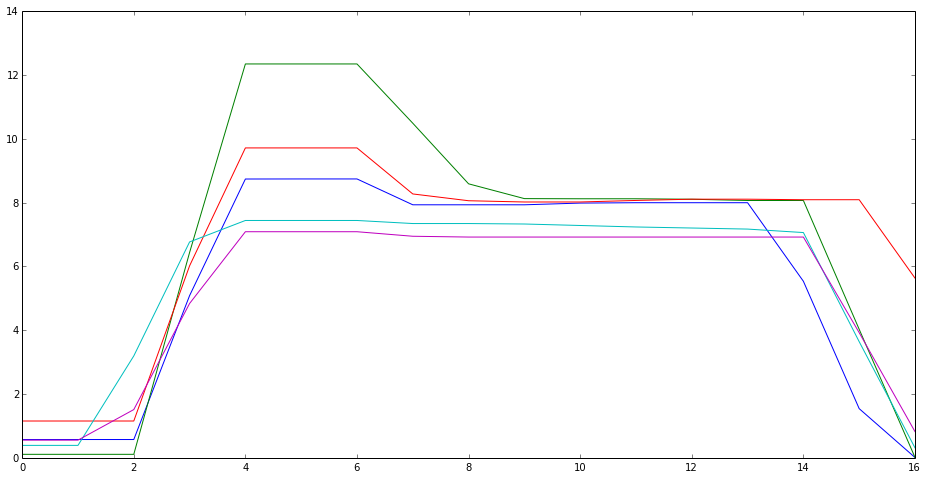

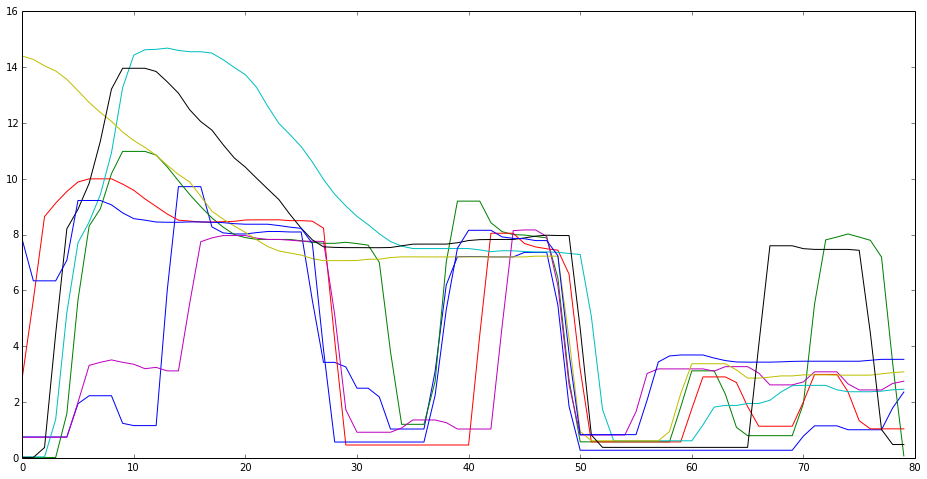

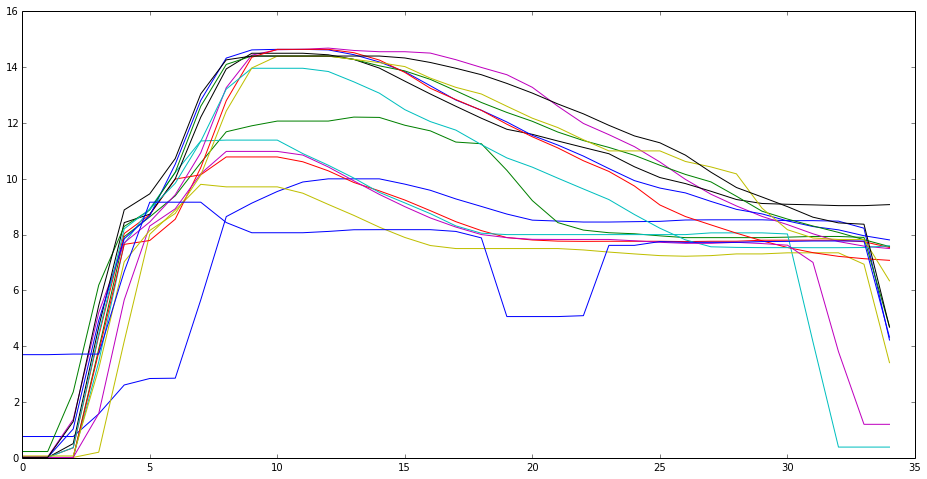

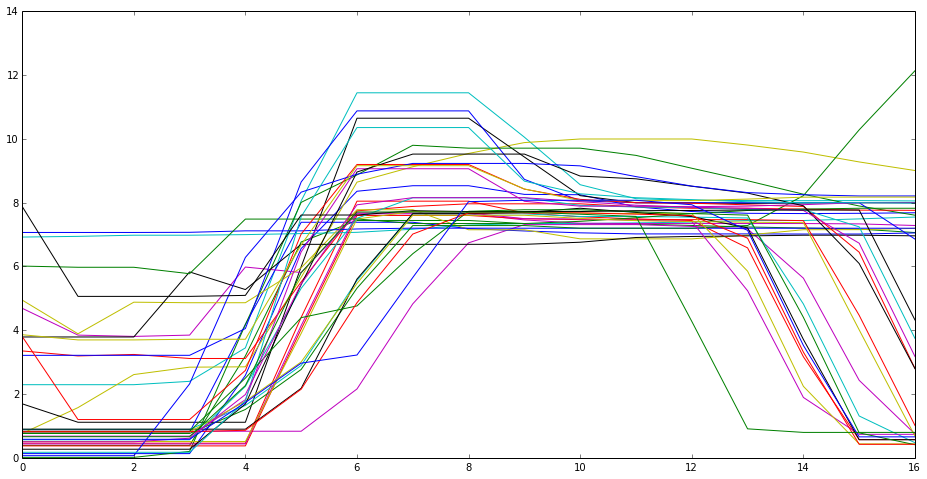

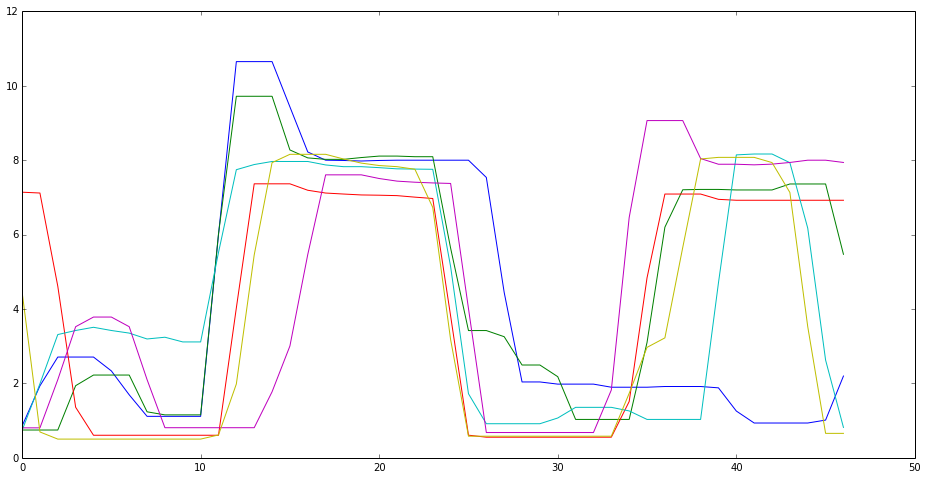

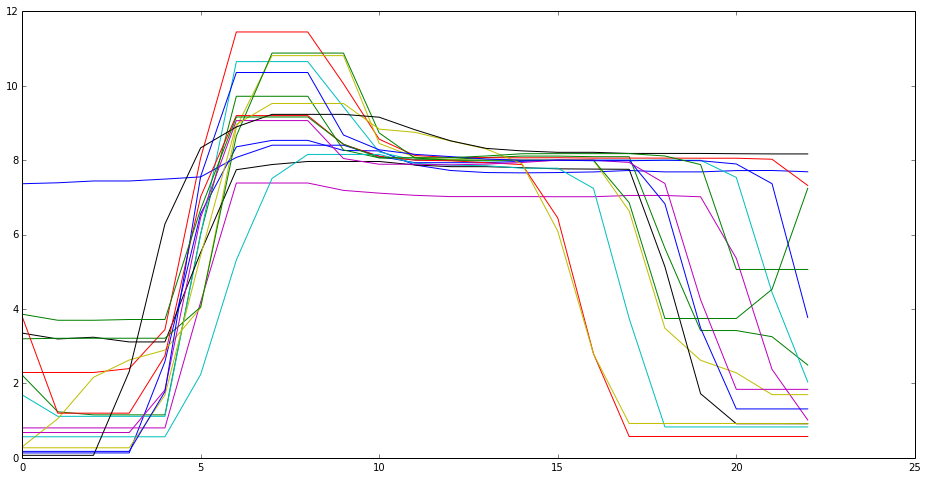

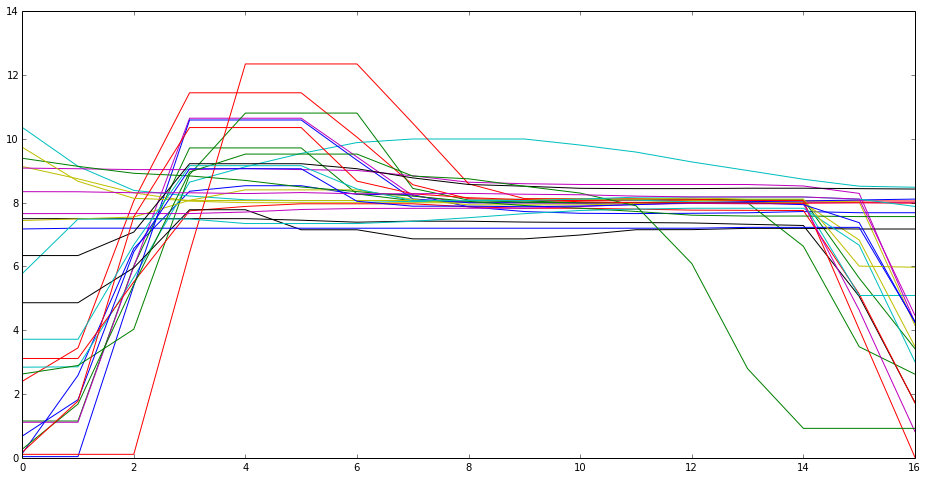

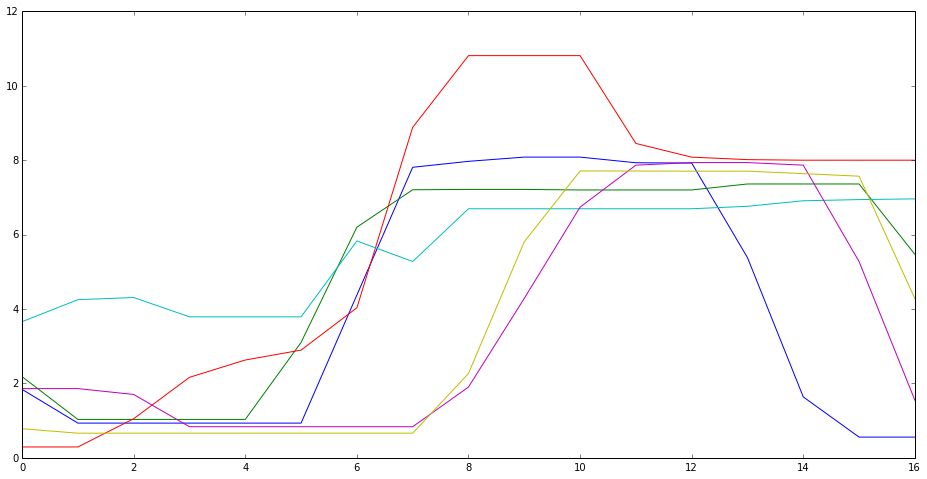

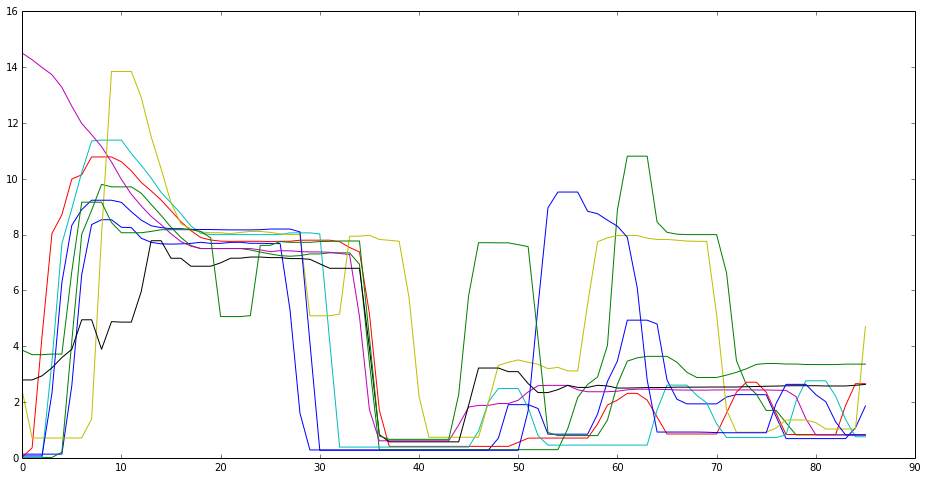

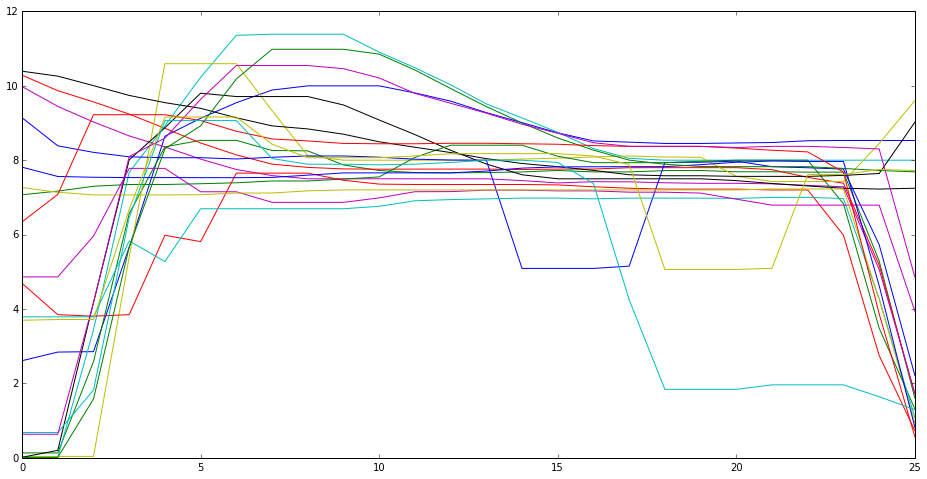

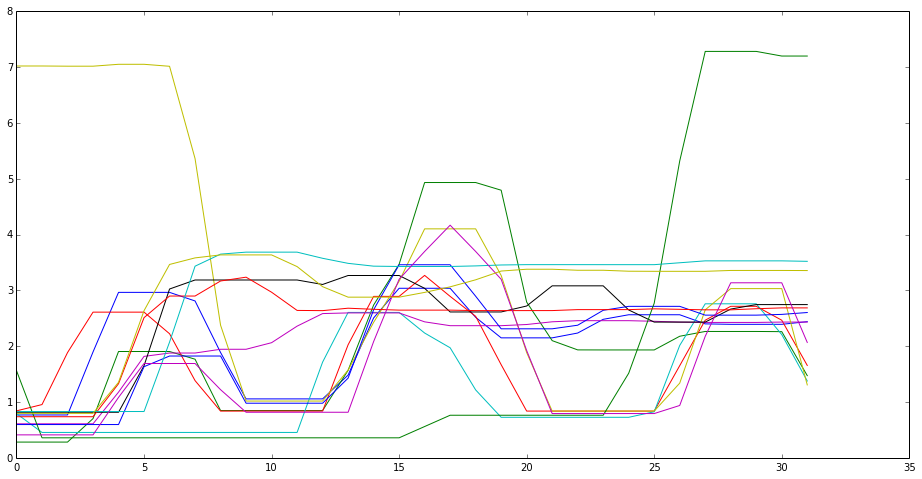

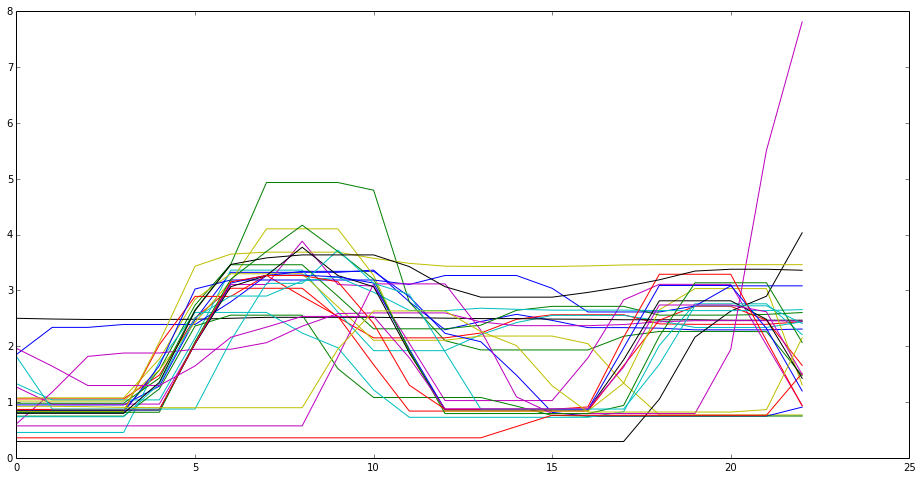

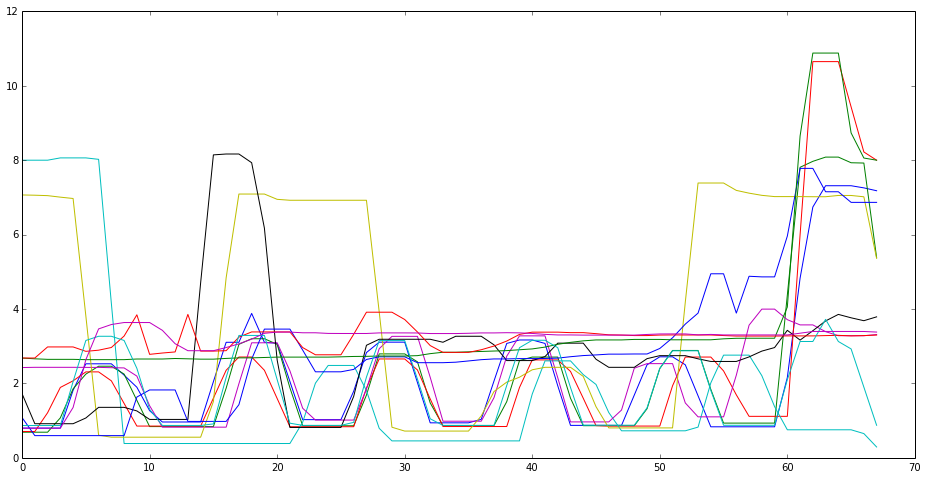

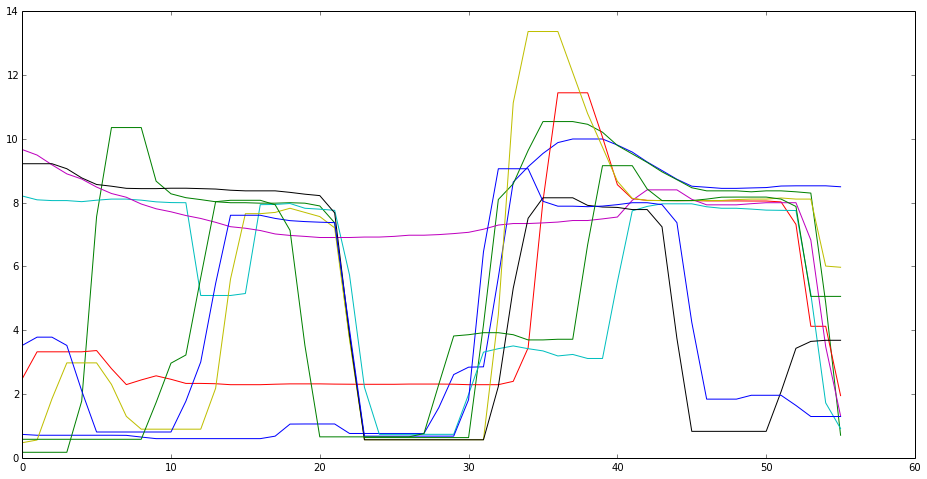

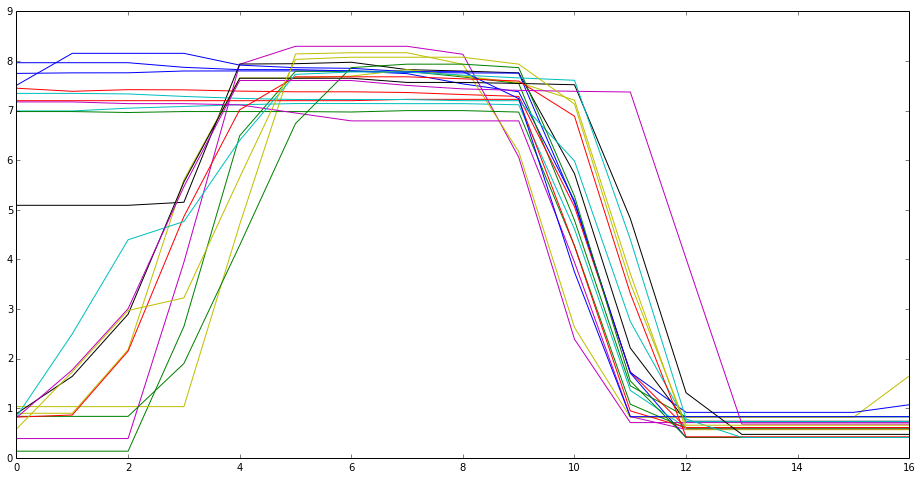

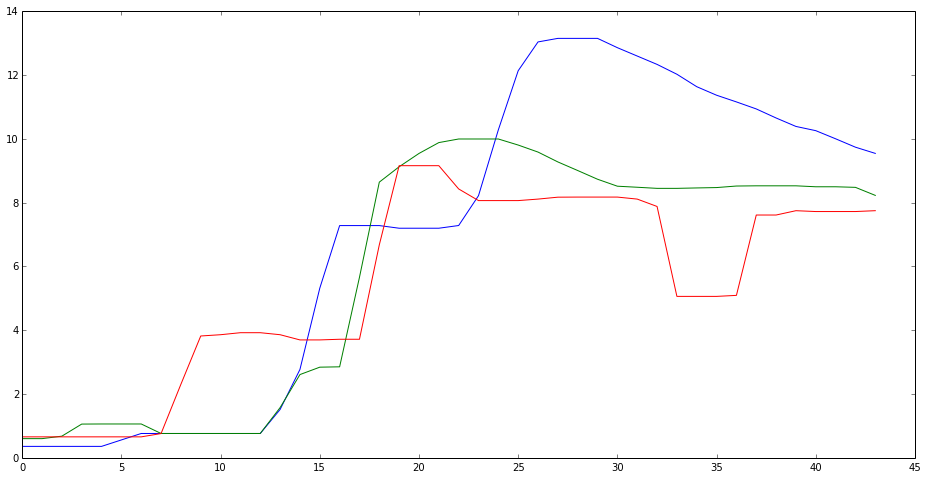

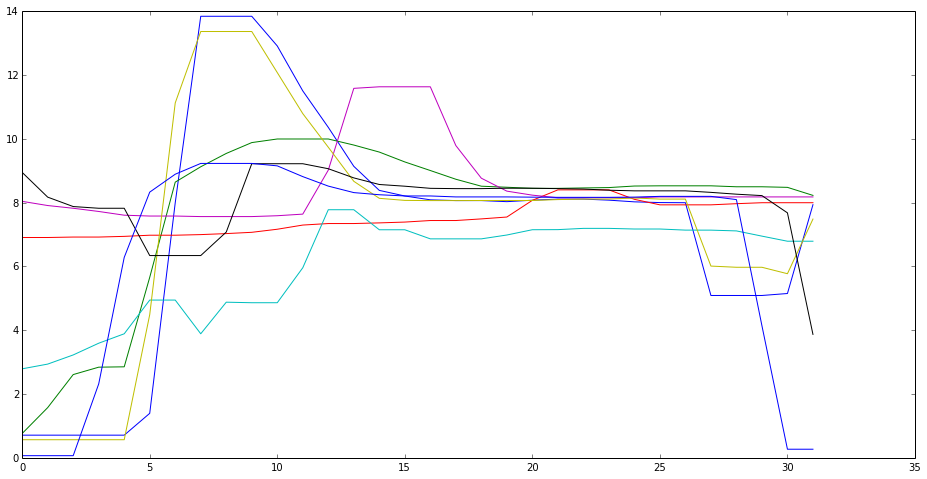

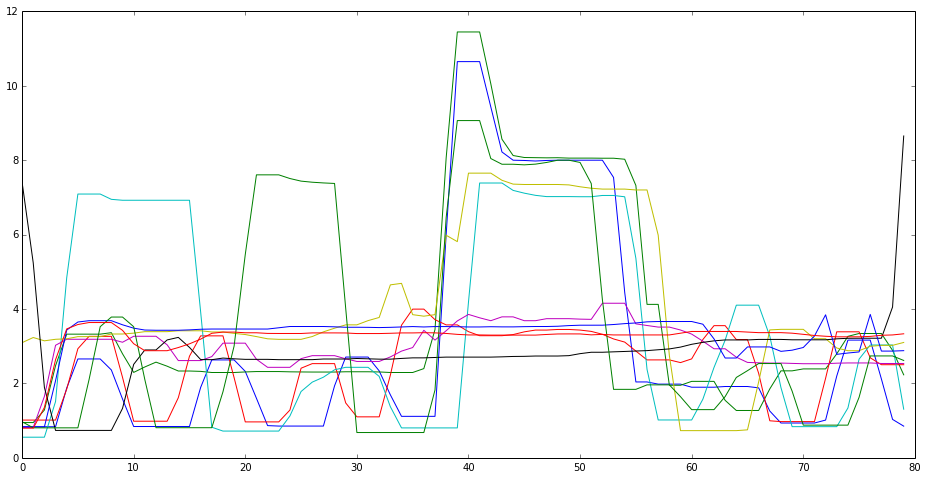

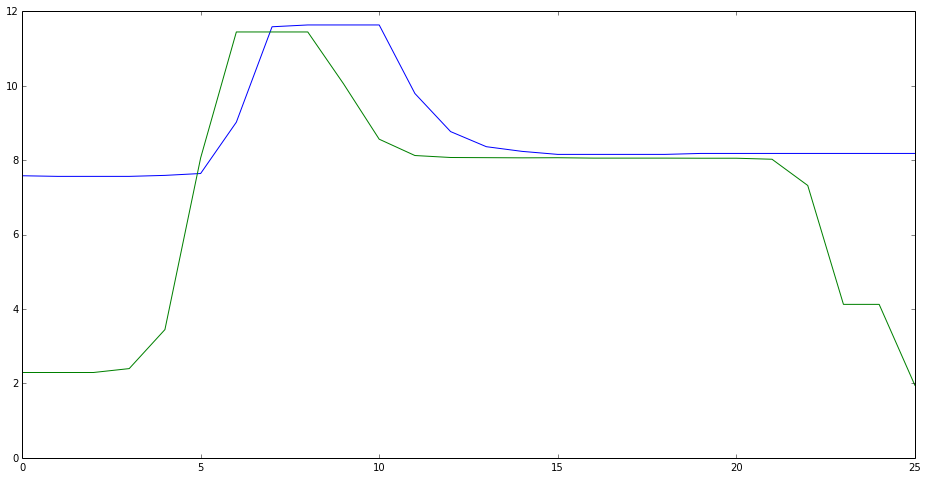

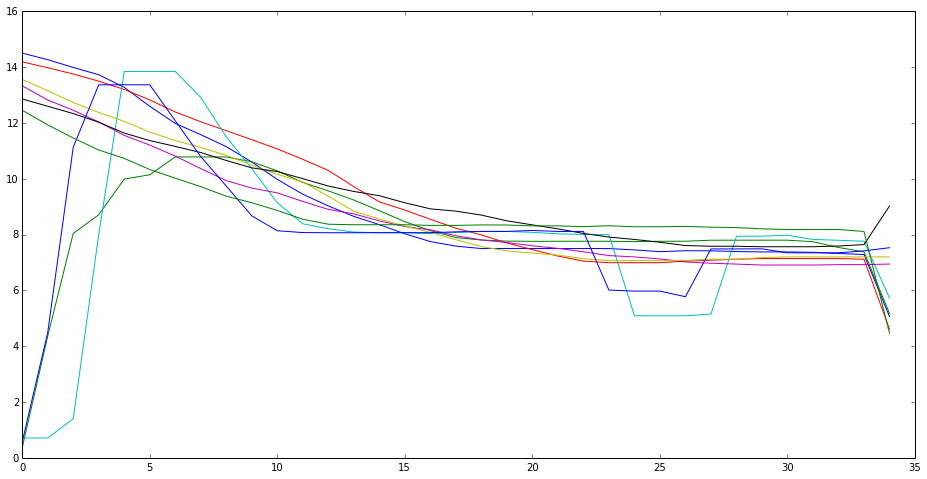

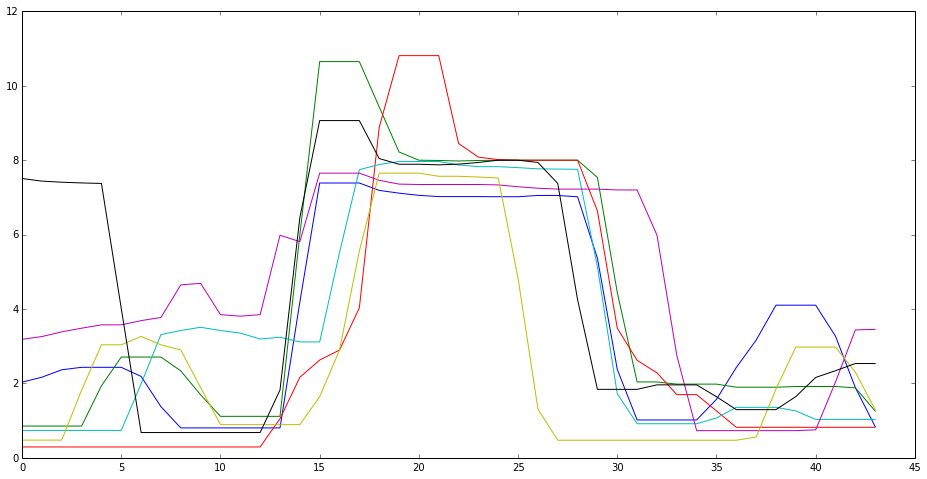

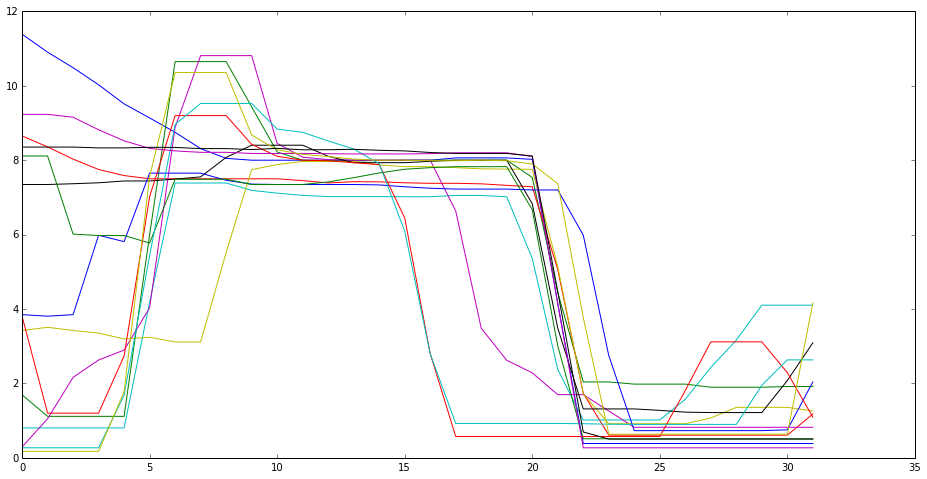

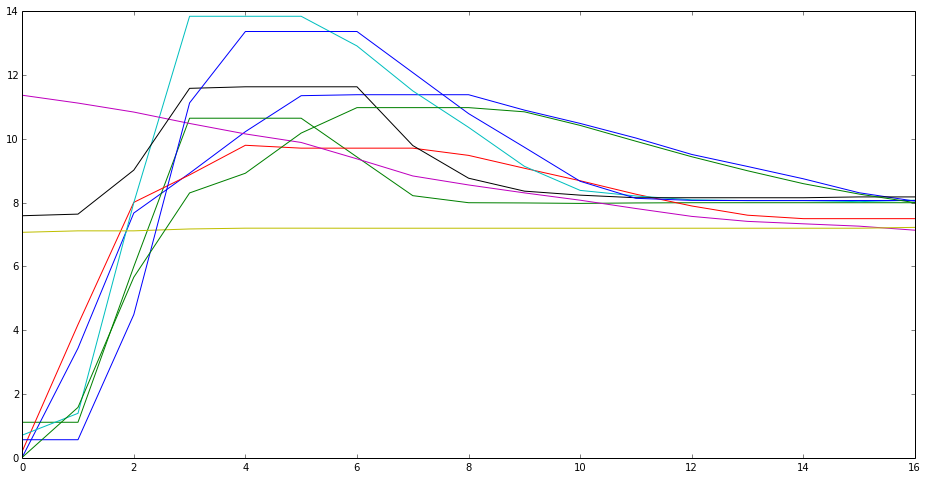

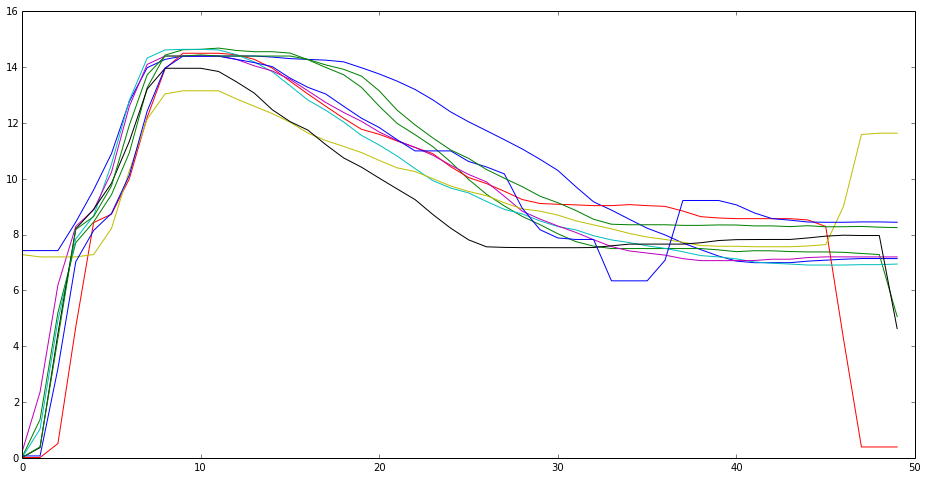

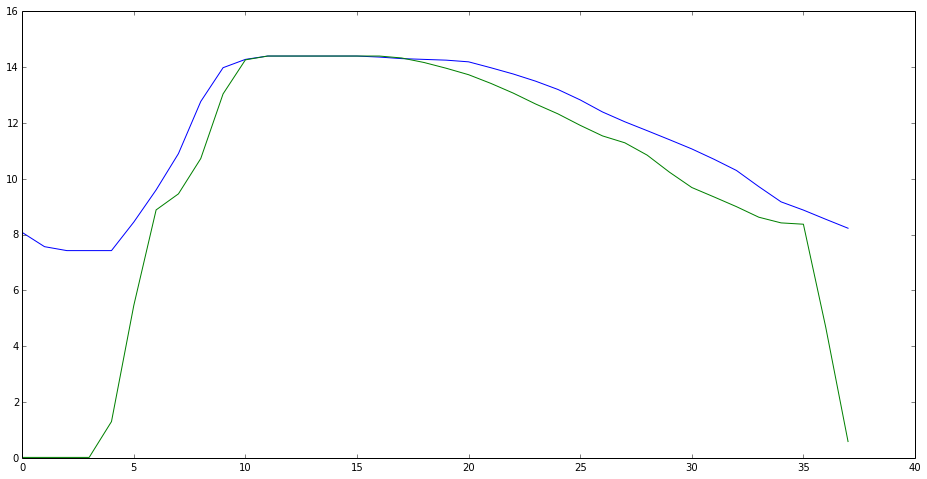

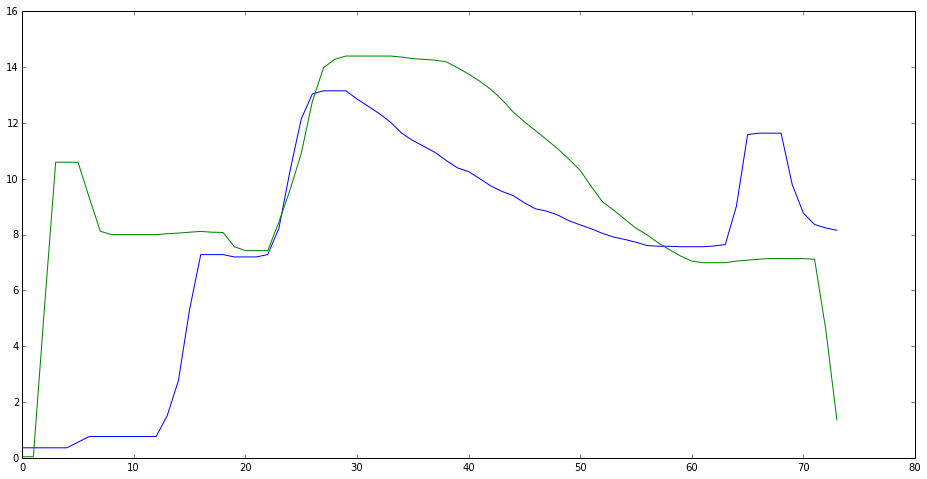

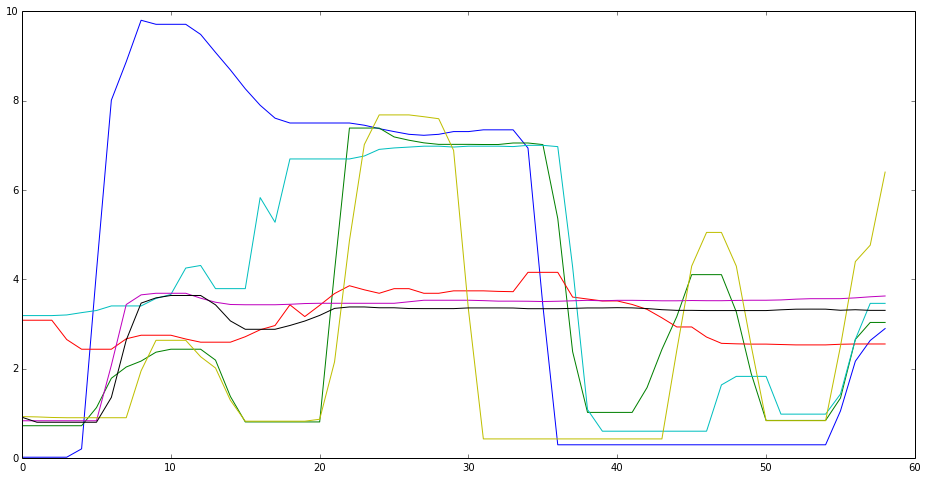

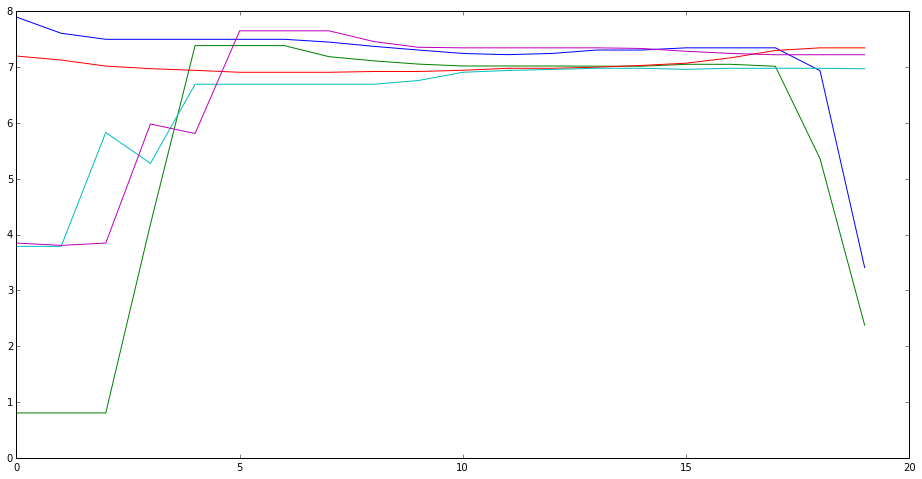

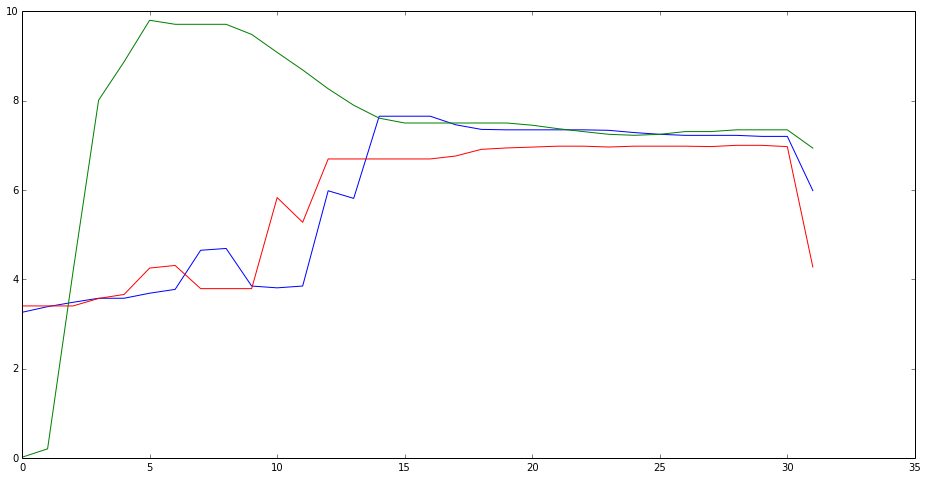

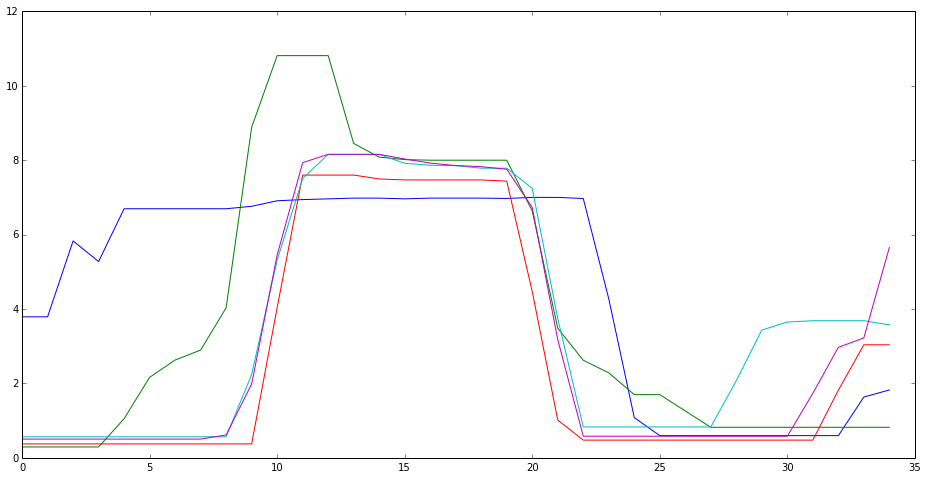

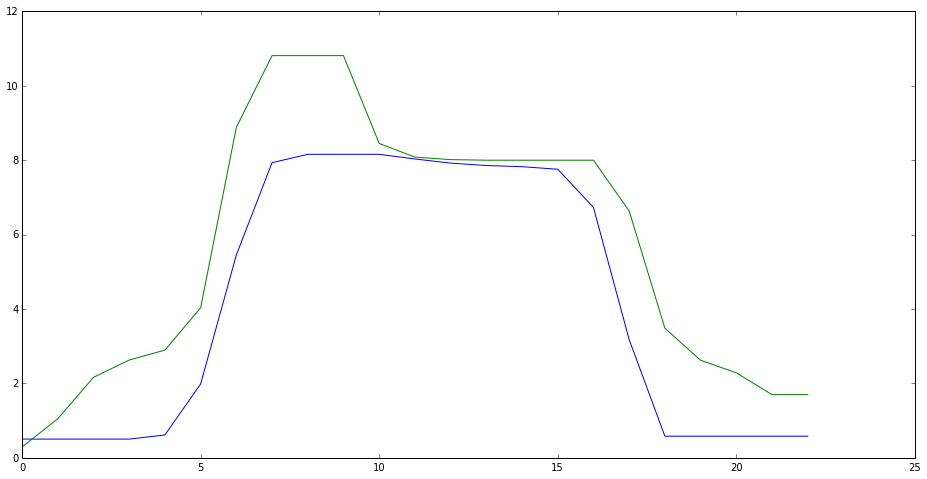

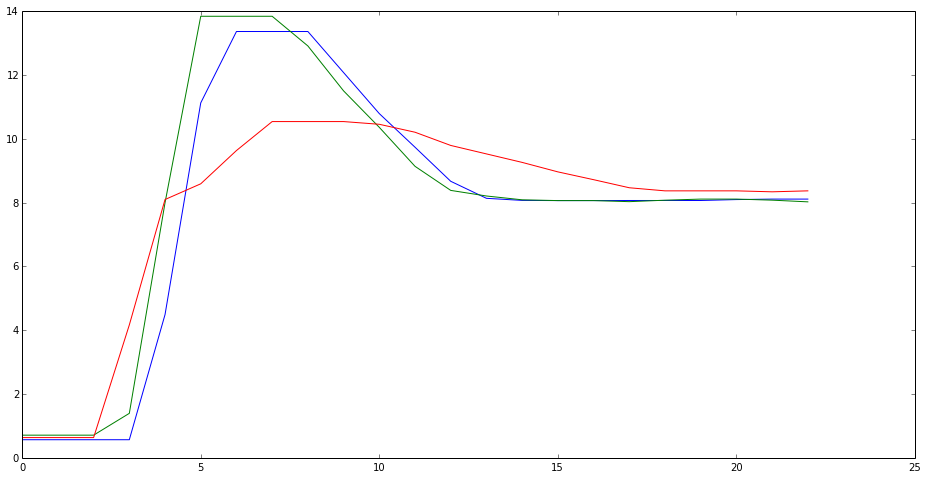

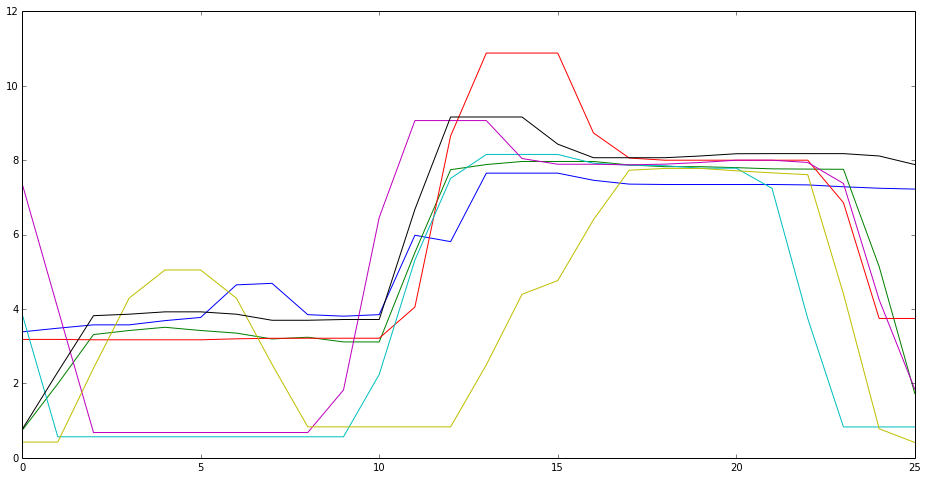

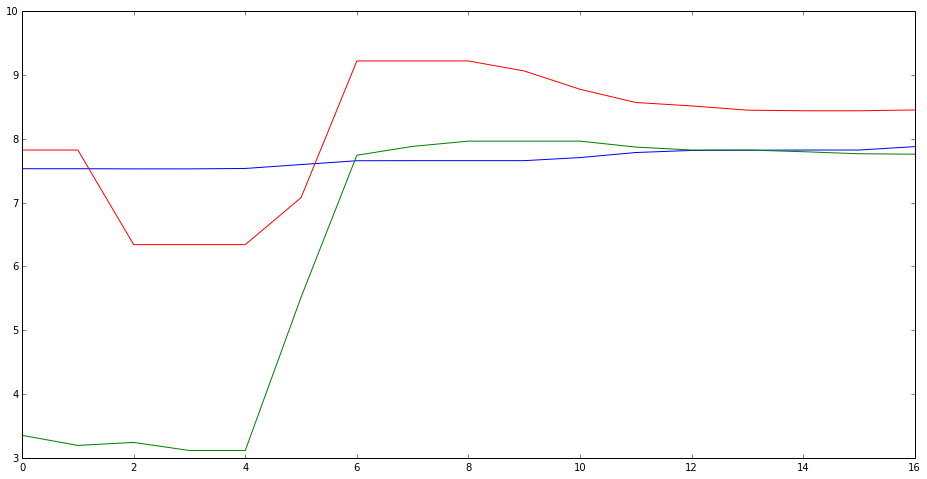

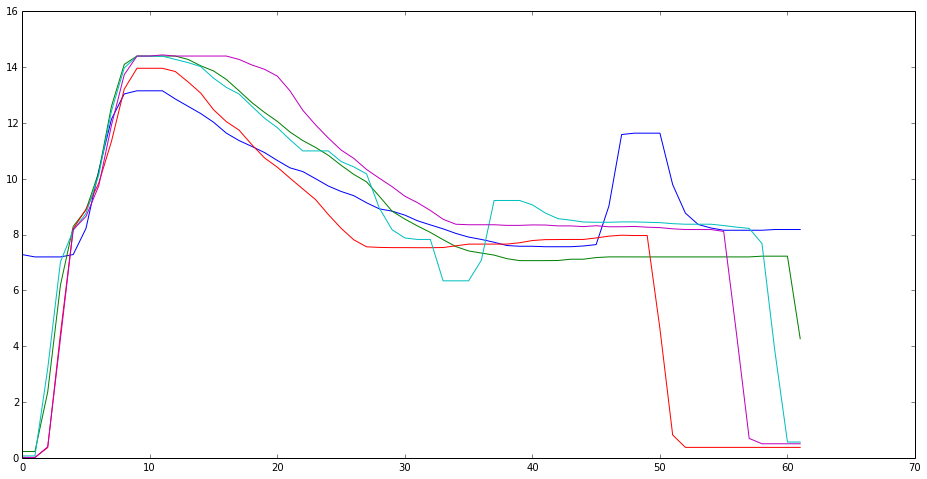

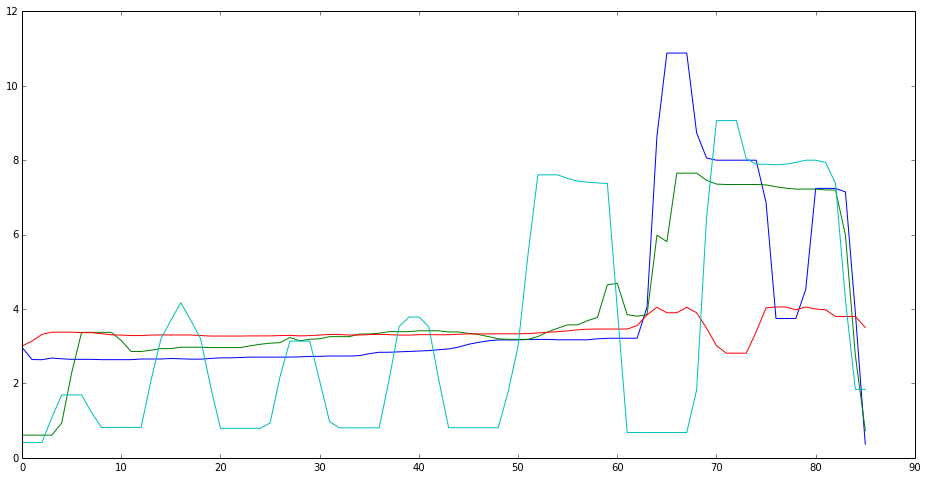

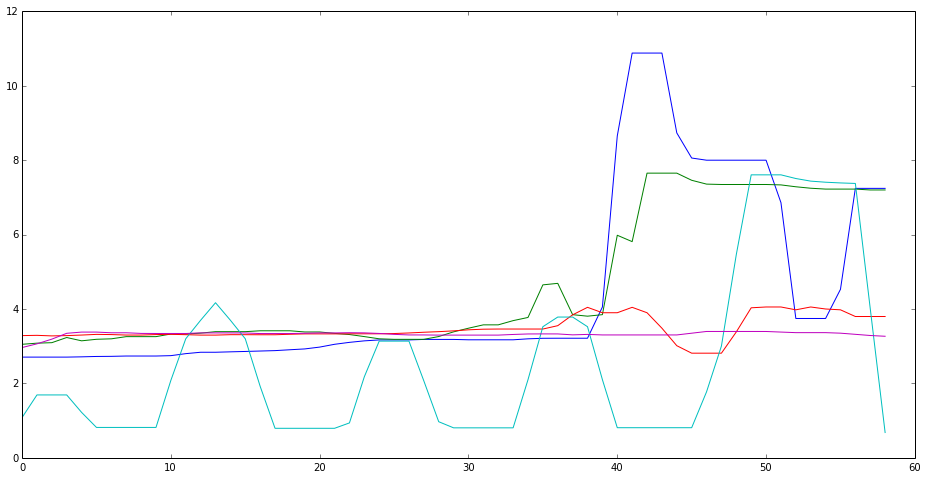

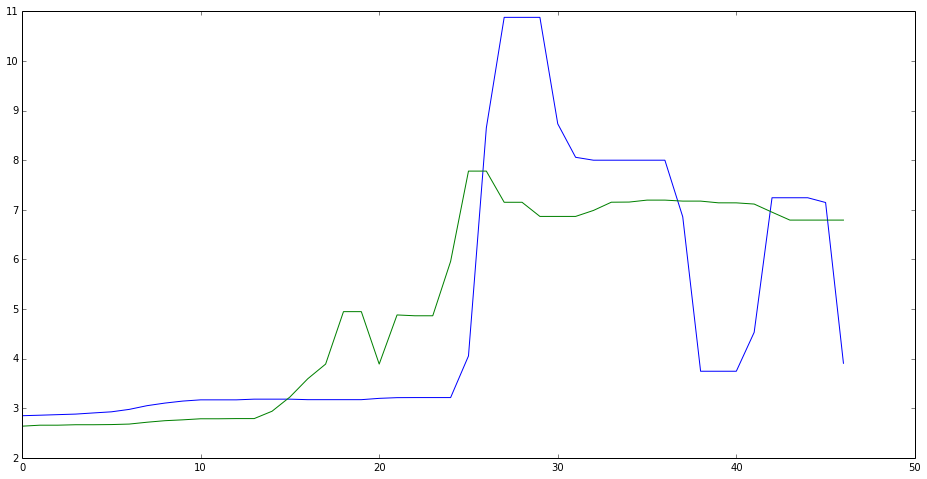

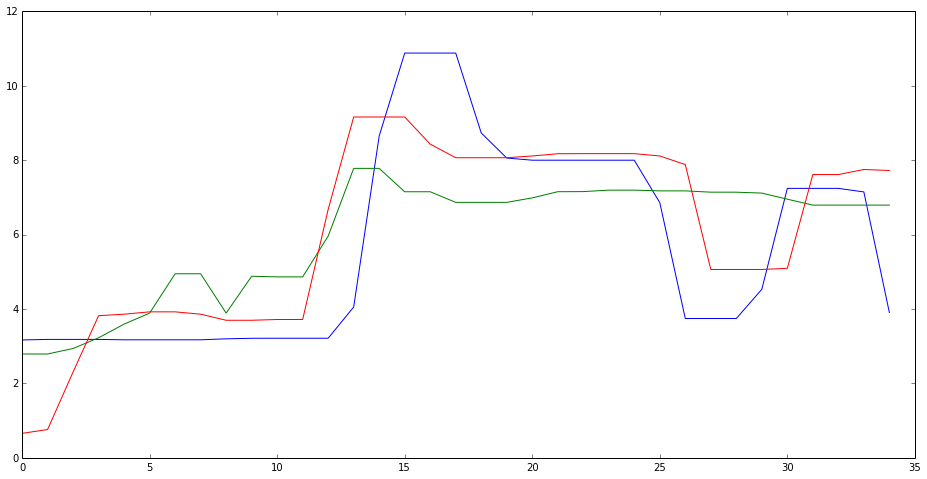

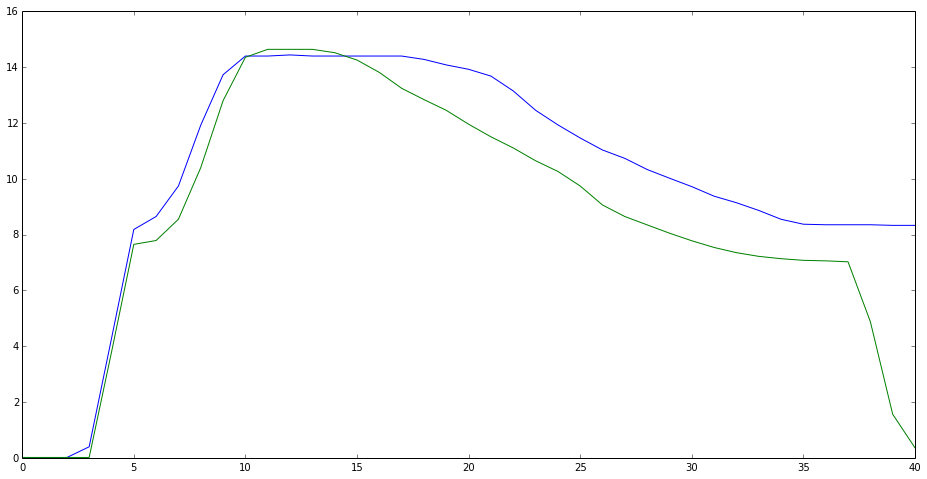

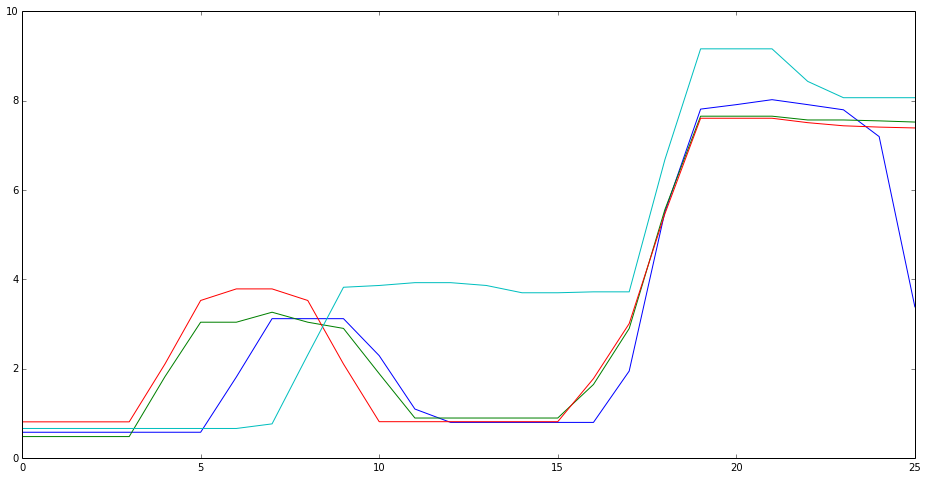

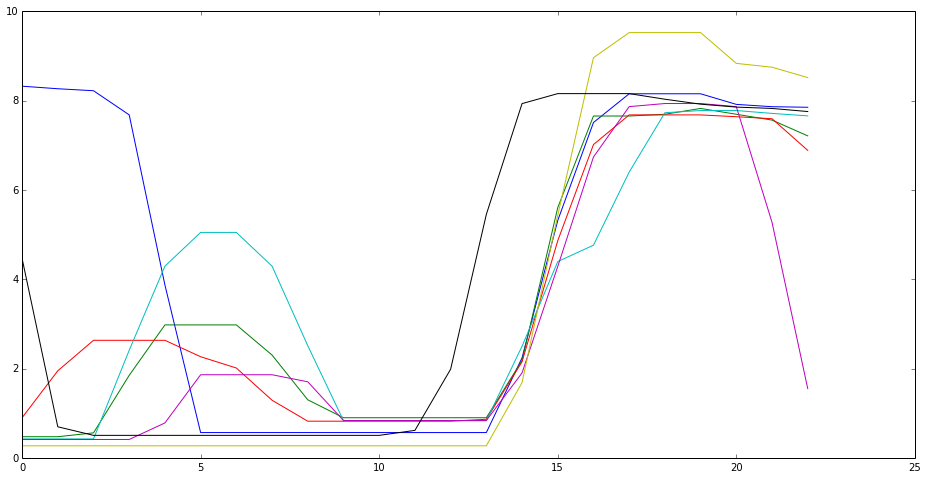

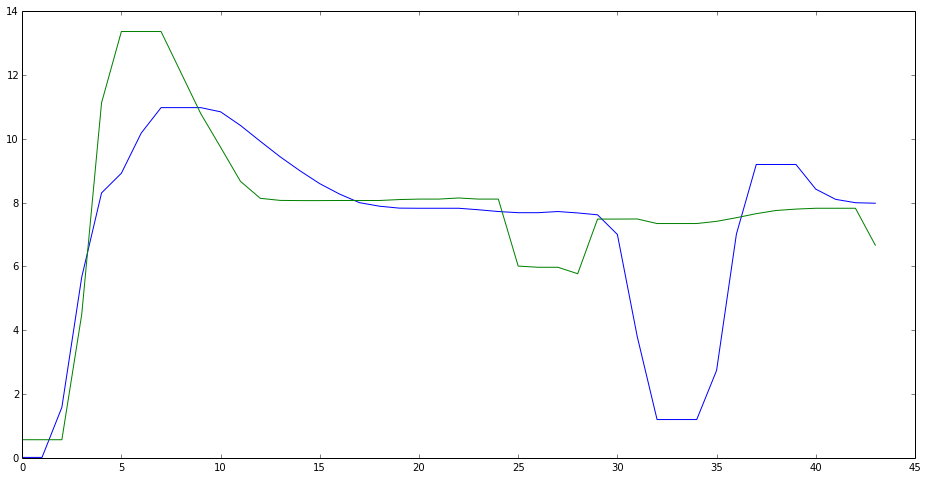

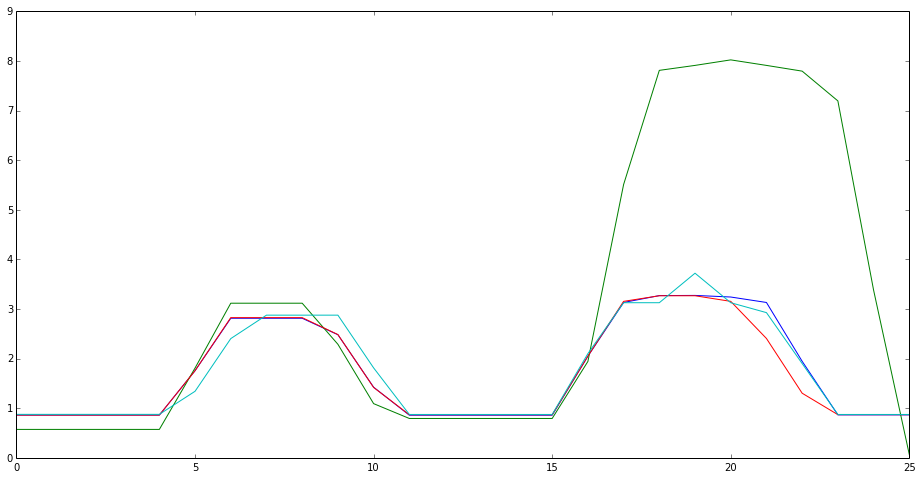

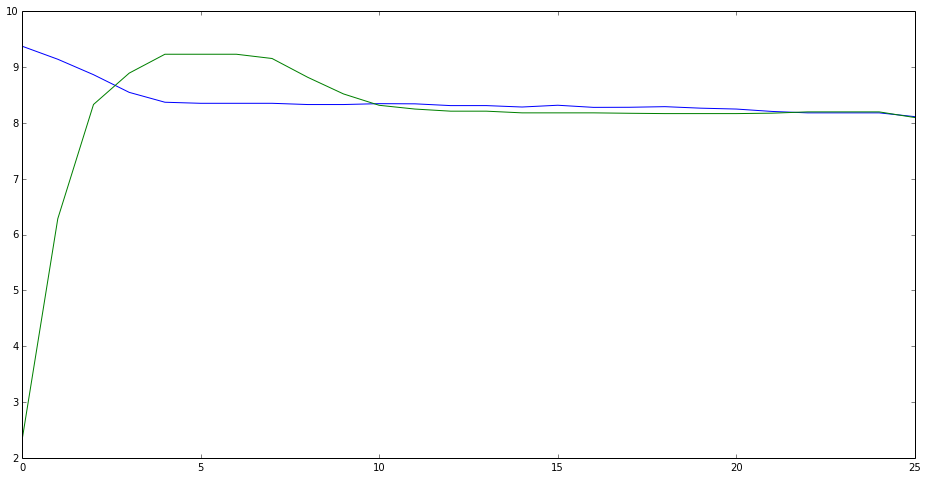

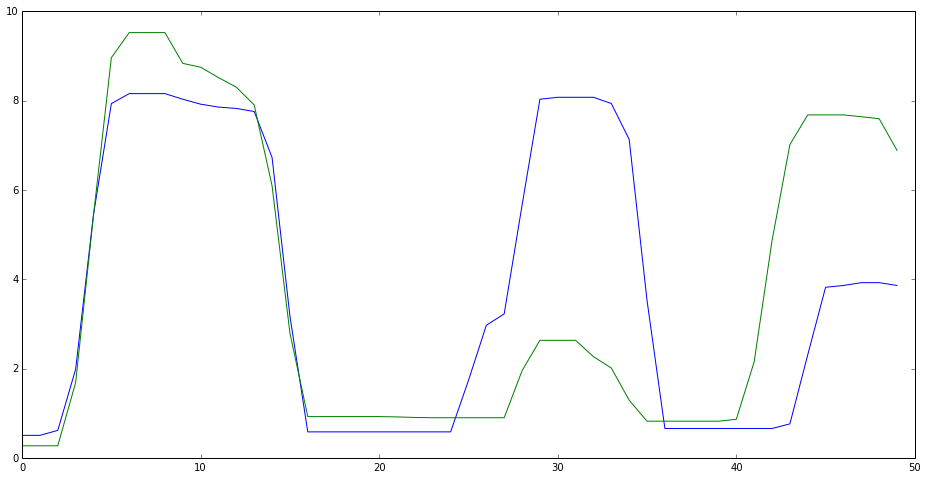

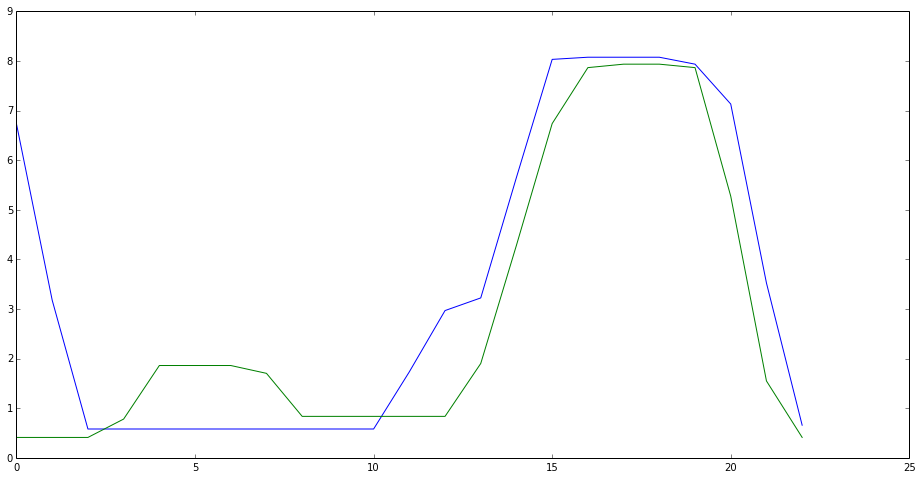

In [194]:
for i in range(0, 81):
    type_0 = type_assigned.loc[type_assigned['type']==i]
    for i in range(0, type_0.index.size):
        plt.plot(df_rm.ix[type_0.iloc[i]['start']:type_0.iloc[i]['stop']])
    plt.show()

In [195]:
type_ = type_assigned.loc[type_assigned['type'] == 1]

In [203]:
type_assigned.sort_values("type").iloc[-1]['type']

46

In [213]:
sorted_val=type_assigned.sort_values("start")

In [239]:
view_l=[]
view_l.append((1,2))

In [261]:
type_assigned.reset_index(drop=True, inplace=True)

In [798]:
def check_overlap(possible_list, start, stop, type_):  
    list_overlap=[]
    index_list = type_assigned['start'][type_assigned['start'] == start].index.tolist()
    other_list = type_assigned['type'][type_assigned['type'] == type_].index.tolist()    
    index = list(set(index_list).intersection(other_list))
    for i in range(0, possible_list.index.size):
#         print "index:", index, "i:",i
        if([i] == index):
#             print "arrived"
            list_overlap.append((possible_list['type'][i], 0))
        elif pd.Timestamp(start) >= pd.Timestamp(possible_list['start'].iloc[i]) and pd.Timestamp(stop) <= pd.Timestamp(possible_list['stop'].iloc[i]):
                if(possible_list['type'][i] != type_):
                    list_overlap.append((possible_list['type'][i],possible_list['start'][i], possible_list['stop'][i]))
        elif pd.Timestamp(start) >= pd.Timestamp(possible_list['start'].iloc[i]) and pd.Timestamp(stop) >= pd.Timestamp(possible_list['stop'].iloc[i]):
            if (pd.Timestamp(possible_list['stop'].iloc[i]) - pd.Timestamp(start))/(pd.Timestamp(stop) - pd.Timestamp(start)) >= 0.8:
                list_overlap.append((possible_list['type'][i],possible_list['start'][i], possible_list['stop'][i]))
        elif pd.Timestamp(start) <= pd.Timestamp(possible_list['start'].iloc[i]) and pd.Timestamp(stop) <= pd.Timestamp(possible_list['stop'].iloc[i]):
            if (pd.Timestamp(stop) - pd.Timestamp(possible_list['start'].iloc[i]))/(pd.Timestamp(stop) - pd.Timestamp(start)) >= 0.8:
                list_overlap.append((possible_list['type'][i],possible_list['start'][i], possible_list['stop'][i]))
    return list_overlap

In [1457]:
def check_overlap(possible_list, start, stop, type_):  
    list_overlap=[]
    index_list = type_assigned['start'][type_assigned['start'] == start].index.tolist()
    other_list = type_assigned['type'][type_assigned['type'] == type_].index.tolist()    
    index = list(set(index_list).intersection(other_list))
    for i in range(0, possible_list.index.size):
#         print "index:", index, "i:",i
        if([i] == index):
#             print "arrived"
            list_overlap.append((possible_list['type'][i], 0))
        elif pd.Timestamp(start) >= pd.Timestamp(possible_list['start'].iloc[i]):
            if(abs(pd.Timestamp(possible_list['stop'].iloc[i]) - pd.Timestamp(stop)) <= pd.Timedelta(minutes=5)) and (abs(pd.Timestamp(possible_list['start'].iloc[i]) - pd.Timestamp(start)) <= pd.Timedelta(minutes=5)):
                print "1:", "start",pd.Timestamp(start), "stop",pd.Timestamp(stop),"\n", "other start", possible_list['start'].iloc[i], "other stop", possible_list['stop'].iloc[i]
                if(possible_list['type'][i] != type_):
                    print pd.Timestamp(start), pd.Timestamp(stop), possible_list['stop'].iloc[i]
                    list_overlap.append((possible_list['type'][i],possible_list['start'][i], possible_list['stop'][i]))
    return list_overlap

In [1619]:
def check_overlap(possible_list, start, stop): 
    ts =(pd.Timestamp(stop) -pd.Timestamp(start))/6.0
    threshold_value=(ts / np.timedelta64(1, 'm')).astype(int)
    list_overlap=[]
    for i in range(0, possible_list.index.size):
        if(abs(pd.Timestamp(possible_list['stop'].iloc[i]) - pd.Timestamp(stop)) <= pd.Timedelta(minutes=threshold_value)) and (abs(pd.Timestamp(possible_list['start'].iloc[i]) - pd.Timestamp(start)) <= pd.Timedelta(minutes=threshold_value)):
                list_overlap.append((possible_list['type'][i],possible_list['start'][i], possible_list['stop'][i]))
    return list_overlap

In [1622]:
test = check_overlap(type_assigned, type_assigned['start'][378], type_assigned['stop'][378])


In [630]:
#Kijk voor ts en types waar ze voorkomen
#Indien multiple types houd count bij waar ze voorkomen (Type, Ts, Waar)
#Kijken hoeveel keer een bepaald Type in een ander Type voorkomt
#Indien deze 30% voorkomt in ander type: Geef ze zelfde type

In [716]:
def func(a, b):
    return not set(a).isdisjoint(b)

In [1433]:
test = check_overlap(type_assigned, type_assigned['start'][40], type_assigned['stop'][40], type_assigned['type'][40])


In [1434]:
test

[(3, 0)]

In [792]:
index_list = type_assigned['start'][type_assigned['start'] == type_assigned['start'][39]].index.tolist()

other_list = type_assigned['type'][type_assigned['type'] == type_assigned['type'][39]].index.tolist()

In [1455]:
def give_same_type():
    type_checked_compare = []
    list_types=[]
    for i in range(0, len(type_assigned)):
#         print i
        overlap = check_overlap(type_assigned, type_assigned['start'][i], type_assigned['stop'][i], type_assigned['type'][i])
        
        type_checked = overlap[[row[1] for row in overlap].index(0)][0]
        for i in range(0, len(overlap)):
            if(overlap[i][1] != 0):
                list_types.append(overlap[i][0])
        if(list_types):
            type_checked_compare.append({type_checked: list_types})
        list_types = []
    return type_checked_compare

In [1458]:
list_comp = give_same_type()

1: start 2015-11-15 08:54:00+00:00 stop 2015-11-15 09:10:00+00:00 
other start 2015-11-15 08:54:00+00:00 other stop 2015-11-15 09:10:00+00:00
2015-11-15 08:54:00+00:00 2015-11-15 09:10:00+00:00 2015-11-15 09:10:00+00:00
1: start 2015-11-10 18:56:00+00:00 stop 2015-11-10 19:12:00+00:00 
other start 2015-11-10 18:54:00+00:00 other stop 2015-11-10 19:16:00+00:00
2015-11-10 18:56:00+00:00 2015-11-10 19:12:00+00:00 2015-11-10 19:16:00+00:00
1: start 2015-11-10 17:47:00+00:00 stop 2015-11-10 18:03:00+00:00 
other start 2015-11-10 17:45:00+00:00 other stop 2015-11-10 18:01:00+00:00
2015-11-10 17:47:00+00:00 2015-11-10 18:03:00+00:00 2015-11-10 18:01:00+00:00
1: start 2015-11-15 05:49:00+00:00 stop 2015-11-15 06:23:00+00:00 
other start 2015-11-15 05:48:00+00:00 other stop 2015-11-15 06:28:00+00:00
2015-11-15 05:49:00+00:00 2015-11-15 06:23:00+00:00 2015-11-15 06:28:00+00:00
1: start 2015-11-17 05:14:00+00:00 stop 2015-11-17 05:48:00+00:00 
other start 2015-11-17 05:12:00+00:00 other stop 2015

In [1470]:
d = {}
for i in list_comp:
    k = list(i.keys())[0]
    d.setdefault(k, [])
    d[k] = d[k] + i[k]

print(d)

{0: [6, 5, 3], 32: [28, 41], 2: [39, 24], 3: [5, 33, 7, 5, 5, 32, 30, 7], 5: [18, 30, 9, 32, 32], 6: [3, 5, 0, 5, 3, 5, 3, 3, 5, 22, 5, 7, 30, 3, 5, 33, 5, 3, 22, 9, 0, 3, 33, 3, 5, 3, 5, 3, 5, 3, 5], 7: [46], 9: [2, 16, 5, 5, 31, 5], 43: [40], 44: [16], 14: [6, 6, 3, 3, 7, 3, 3, 3, 3], 16: [2, 38], 18: [5], 19: [2], 21: [29], 22: [3, 5, 6, 3, 31, 3, 9, 18, 31], 46: [41], 33: [3], 27: [3, 5, 3, 9, 3, 9], 28: [2], 30: [5]}


In [1508]:
d

{0: [6, 5, 3],
 2: [39, 24],
 3: [5, 33, 7, 5, 5, 32, 30, 7],
 5: [18, 30, 9, 32, 32],
 6: [3,
  5,
  0,
  5,
  3,
  5,
  3,
  3,
  5,
  22,
  5,
  7,
  30,
  3,
  5,
  33,
  5,
  3,
  22,
  9,
  0,
  3,
  33,
  3,
  5,
  3,
  5,
  3,
  5,
  3,
  5],
 7: [46],
 9: [2, 16, 5, 5, 31, 5],
 14: [6, 6, 3, 3, 7, 3, 3, 3, 3],
 16: [2, 38],
 18: [5],
 19: [2],
 21: [29],
 22: [3, 5, 6, 3, 31, 3, 9, 18, 31],
 27: [3, 5, 3, 9, 3, 9],
 28: [2],
 30: [5],
 32: [28, 41],
 33: [3],
 43: [40],
 44: [16],
 46: [41]}

In [1488]:
value = d[0]

In [1588]:
c = type_assigned.copy()

In [1589]:
value = c.loc[c['type'].isin([5,6, 14, 22, 27, 30])]

In [1590]:
for i in range(0, len(value)):
    current_index = value.index[i]
    c['type'][current_index]=3

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


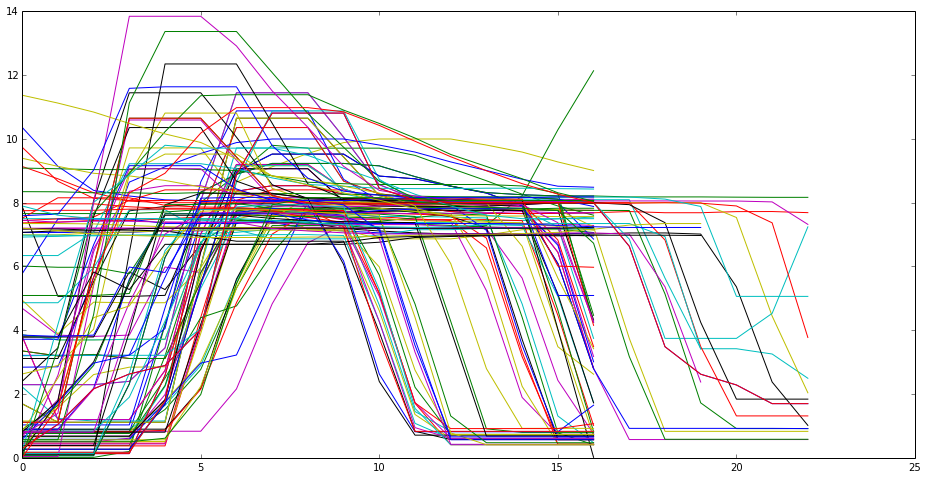

In [1591]:
    type_0 = c.loc[c['type']==3]
    for i in range(0, type_0.index.size):
        plt.plot(df_rm.ix[type_0.iloc[i]['start']:type_0.iloc[i]['stop']])
    plt.show()

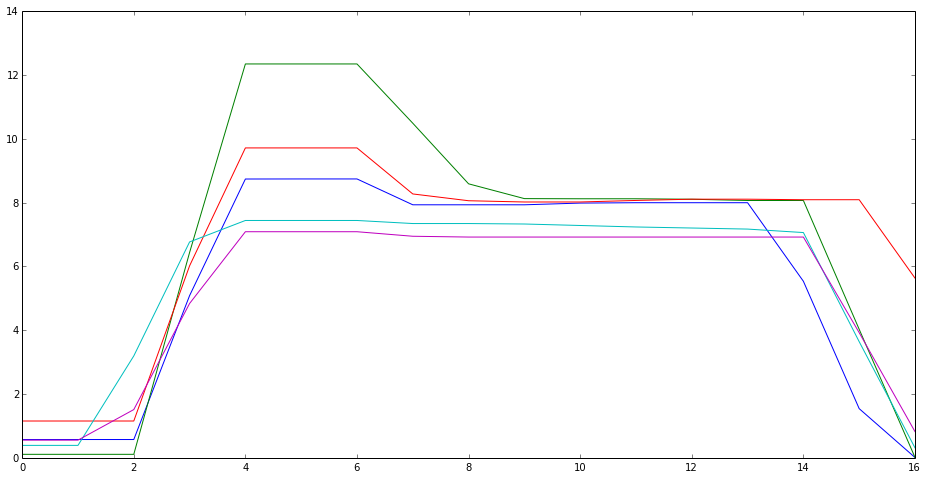

In [1538]:
    type_0 = type_assigned.loc[type_assigned['type']==0]
    for i in range(0, type_0.index.size):
        plt.plot(df_rm.ix[type_0.iloc[i]['start']:type_0.iloc[i]['stop']])
    plt.show()

In [1028]:
list_comp[1].items()

[(0, [1, 4, 5, 6])]

In [ ]:
any(list_comp['name'] == 'Test' for d in label)

In [1053]:
df_list_comp = pd.DataFrame(list_comp)

In [3684]:
def find_type_if_in_list(list_, start_nn, stop_nn):
    ts =(pd.Timestamp(stop_nn) -pd.Timestamp(start_nn))/8.0
    threshold_value=(ts / np.timedelta64(1, 'm')).astype(int)
    type_to_find = None
    # print threshold_value
    for i in range(0, len(list_)):
        start_nn = pd.Timestamp(start_nn)
        stop_nn = pd.Timestamp(stop_nn)
        start_list =  pd.Timestamp(list_[i][1][2])
        stop_list = pd.Timestamp(list_[i][1][3])
        threshold =  pd.Timedelta(minutes = threshold_value)
#         print start_nn, stop_nn, start_list-threshold, start_list+threshold, stop_list+threshold
        if(start_nn >= start_list-threshold) and (start_nn <= start_list+threshold ) and (stop_nn <= stop_list+threshold):
#             print "ok"
            if(abs(stop_list -stop_nn) <= threshold):
#                 print "ok"
                index = list_[i][0]
                type_to_find = list_[index][1][1]
    return type_to_find

In [3744]:
# def assign_type(df, blocks_list):
#     #types of blocks
#     type_block = 0
#     #contains the list with the types from the original dataframe (type_ori)
#     list_types_ori = []
#     #new dataframe created with types for each similar block (type_block)
#     df_types_block =[]
#     df_types_block = pd.DataFrame(df_types_block)
#     for i in range(0, df.index.size):
#         start_ts = df.iloc[i]['start']
#         stop_ts = df.iloc[i]['stop']
#         #Storing type_ori - used for searching
#         type_in_df_ori = df.iloc[i]['original']
#         #Finding your type in the list with saved types_ori
#         find_type = [row[0] for row in list_types_ori]   
            
#         if(type_in_df_ori not in find_type):
#             current_type_block = type_block
#             #Find the start and stop timestamps of the block in the blocklist
#             ind = blocks_list.loc[blocks_list['Type']==type_in_df_ori].index[0]
#             start_ts_ori = pd.Timestamp(blocks_list.iloc[ind]['start'])
#             stop_ts_ori = pd.Timestamp(blocks_list.iloc[ind]['stop'])
#             #add type_ori to list_types_ori so that it cannot be assigned again
#             #assign type_new to this type_ori
#             list_types_ori.append([type_in_df_ori, type_block, start_ts, stop_ts])
#             #Store the data
#             data = [[start_ts, stop_ts, current_type_block], [start_ts_ori, stop_ts_ori, current_type_block]]
#             #augment type_block
#             type_block = type_block +1
#         else:
#             #Type is already present: find the type_blocks associated with it!
#             index = find_type.index(type_in_df_ori)
#             #Find current_type, look in the list, dependent on the index of the ori value
#             current_type_block = list_types_ori[index][1]
#             #New data will not contain the ori now since it is already present
#             data = [[start_ts, stop_ts, current_type_block]]
#         df_types_block = df_types_block.append(pd.DataFrame(data, columns=('start','stop','type')))
#     return df_types_block

In [3738]:
types_assigned = assign_type(drop, blocks)

In [ ]:
blocks

In [ ]:
type_0['start'].iloc[0]

In [ ]:
plt.plot(data.ix[pd.Timestamp(split_matches['startTimeStamp'].iloc[i]) - pd.Timedelta(minutes=2):pd.Timestamp(split_matches['stopTimeStamp'].iloc[i]) + pd.Timedelta(minutes=2)])     


<h3> Creating pickle to save list_view </h3>

In [ ]:
pickle_out = open("list_view.pickle", "wb")
pickle.dump(list_view, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("list_view.pickle", "rb")

In [ ]:
example = pickle.load(pickle_in)

In [ ]:
example

In [ ]:
# sorted_values=storing_length_and_score.sort_values('score')
# sorted_values.reset_index(drop=True, inplace=True)
# sorted_values['bratio']=1.0
# for i in range(0,sorted_values.index.size):
#     result = sorted_values.loc[i][0]/sorted_values.loc[i][1]
# #     print "result 1: ",result
#     sorted_values['ratio'][i] = result
# #     print "result 2: ",result
# #     print "ratio result: ",storing_length_and_score_sorted['ratio'][i]

In [3726]:
types_assigned_2 = assign_type(drop, blocks)

In [3732]:
types_assigned_2.sort_values("type")

start                      stop  type
0  2015-11-10 07:06:00+00:00 2015-11-10 07:22:00+00:00     0
0  2015-11-15 07:39:00+00:00 2015-11-15 07:55:00+00:00     0
0  2015-11-15 07:39:00+00:00 2015-11-15 07:55:00+00:00     0
0  2015-11-11 10:56:00+00:00 2015-11-11 11:12:00+00:00     0
0  2015-11-12 18:57:00+00:00 2015-11-12 19:13:00+00:00     0
0  2015-11-11 10:56:00+00:00 2015-11-11 11:12:00+00:00     0
0  2015-11-11 10:56:00+00:00 2015-11-11 11:12:00+00:00     0
0  2015-11-15 21:19:00+00:00 2015-11-15 21:35:00+00:00     0
0  2015-11-11 20:17:00+00:00 2015-11-11 20:33:00+00:00     0
0  2015-11-16 06:19:00+00:00 2015-11-16 06:35:00+00:00     0
0  2015-11-16 09:36:00+00:00 2015-11-16 09:52:00+00:00     0
0  2015-11-11 07:36:00+00:00 2015-11-11 07:52:00+00:00     0
0  2015-11-11 06:56:00+00:00 2015-11-11 07:12:00+00:00     0
0  2015-11-11 06:56:00+00:00 2015-11-11 07:12:00+00:00     0
0  2015-11-11 06:56:00+00:00 2015-11-11 07:12:00+00:00     0
0  2015-11-16 15:10:00+00:00 2015-11-16 15:26:00+00:00     0
0  2015-11-16 15:57:00+00:00 2015-11-16 16:13:00+00:00     0
0  2015-11-16 09:03:00+00:00 2015-11-16 09:19:00+00:00     0
0  2015-11-16 18:49:00+00:00 2015-11-16 19:05:00+00:00     0
0  2015-11-11 20:17:00+00:00 2015-11-11 20:33:00+00:00     0
0  2015-11-11 20:17:00+00:00 2015-11-11 20:33:00+00:00     0
0  2015-11-12 20:39:00+00:00 2015-11-12 20:55:00+00:00     0
0  2015-11-12 21:15:00+00:00 2015-11-12 21:31:00+00:00     0
0  2015-11-12 21:15:00+00:00 2015-11-12 21:31:00+00:00     0
0  2015-11-13 05:33:00+00:00 2015-11-13 05:49:00+00:00     0
0  2015-11-13 06:26:00+00:00 2015-11-13 06:42:00+00:00     0
0  2015-11-13 06:26:00+00:00 2015-11-13 06:42:00+00:00     0
0  2015-11-13 06:26:00+00:00 2015-11-13 06:42:00+00:00     0
0  2015-11-11 20:17:00+00:00 2015-11-11 20:33:00+00:00     0
0  2015-11-13 17:40:00+00:00 2015-11-13 17:56:00+00:00     0
..                       ...                       ...   ...
0  2015-11-17 17:54:00+00:00 2015-11-17 18:10:00+00:00    72
0  2015-11-16 16:52:00+00:00 2015-11-16 21:47:00+00:00    73
1  2015-11-10 17:00:00+00:00 2015-11-10 21:55:00+00:00    73
0  2015-11-17 06:19:00+00:00 2015-11-17 06:41:00+00:00    74
1  2015-11-16 19:09:00+00:00 2015-11-16 19:31:00+00:00    74
0  2015-11-17 19:09:00+00:00 2015-11-17 19:31:00+00:00    74
0  2015-11-17 18:18:00+00:00 2015-11-17 18:34:00+00:00    75
0  2015-11-17 19:27:00+00:00 2015-11-17 19:43:00+00:00    75
0  2015-11-17 18:40:00+00:00 2015-11-17 18:56:00+00:00    75
1  2015-11-16 15:57:00+00:00 2015-11-16 16:13:00+00:00    75
0  2015-11-17 19:47:00+00:00 2015-11-17 20:03:00+00:00    75
0  2015-11-17 06:19:00+00:00 2015-11-17 06:35:00+00:00    75
0  2015-11-17 19:08:00+00:00 2015-11-17 19:24:00+00:00    75
0  2015-11-17 17:44:00+00:00 2015-11-17 18:09:00+00:00    76
1  2015-11-16 15:12:00+00:00 2015-11-16 15:37:00+00:00    76
0  2015-11-17 06:48:00+00:00 2015-11-17 07:13:00+00:00    76
1  2015-11-16 08:30:00+00:00 2015-11-16 09:28:00+00:00    77
0  2015-11-17 17:13:00+00:00 2015-11-17 18:11:00+00:00    77
0  2015-11-17 18:33:00+00:00 2015-11-17 18:55:00+00:00    78
1  2015-11-16 17:33:00+00:00 2015-11-16 17:55:00+00:00    78
1  2015-11-11 06:42:00+00:00 2015-11-11 07:25:00+00:00    79
0  2015-11-17 18:55:00+00:00 2015-11-17 19:38:00+00:00    79
1  2015-11-15 21:12:00+00:00 2015-11-15 21:40:00+00:00    80
0  2015-11-17 19:03:00+00:00 2015-11-17 19:31:00+00:00    80
0  2015-11-17 19:08:00+00:00 2015-11-17 22:09:00+00:00    81
1  2015-11-16 19:09:00+00:00 2015-11-16 22:10:00+00:00    81
0  2015-11-17 19:10:00+00:00 2015-11-17 19:29:00+00:00    82
1  2015-11-17 06:21:00+00:00 2015-11-17 06:40:00+00:00    82
1  2015-11-16 18:03:00+00:00 2015-11-16 19:04:00+00:00    83
0  2015-11-17 20:00:00+00:00 2015-11-17 21:01:00+00:00    83

[966 rows x 3 columns]